In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#library
!pip install pmdarima
!pip install prophet
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from pmdarima import auto_arima
# from pmdarima.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# from statsmodels.stats.diagnostic import acorr_ljungbox
# from statsmodels.stats.diagnostic import het_white
from datetime import datetime, timedelta
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.2 MB/s eta 0:00:00


# Data Preparation

In [ ]:
#gabung data
df1 = pd.read_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/dataset_2021.csv', sep=';')
df2 = pd.read_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/dataset_2022.csv', sep=';')
df3 = pd.read_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/dataset_2023.csv', sep=';')

df_all = pd.concat([df1, df2, df3], ignore_index=True)

df_all

,Tanggal,Departemen,Gudang,User,Kode Item,NamaItem,Satuan,Jumlah
0,01/01/2021,KELAS I :CIKAHURIPAN COVID[KUNING],5. DEPO FARMASI - RAWAT INAP,"Neni Rohayati, S. Farm.",OBTUL0039,LOVENOX 20 MG/0.2 ML SYRINGES INJ,SRG,2.0
1,01/01/2021,KELAS I :CIKAHURIPAN[KUNING],5. DEPO FARMASI - RAWAT INAP,"Neni Rohayati, S. Farm.",OBTUT0043,TREMENZA TAB,TAB,3.0
2,01/01/2021,KELAS I :CIKAHURIPAN[KUNING],5. DEPO FARMASI - RAWAT INAP,"Neni Rohayati, S. Farm.",OBTUB0010,BECOM ZET TAB (v),TAB,1.0
3,01/01/2021,KELAS I :CIKAHURIPAN[KUNING],5. DEPO FARMASI - RAWAT INAP,"Neni Rohayati, S. Farm.",OBTUR0027,RINGER LACTAT INF SANBE (DP),BAG,6.0
4,01/01/2021,KELAS I :CIWALAGRI[CIWA - 9 - 1],5. DEPO FARMASI - RAWAT INAP,"Neni Rohayati, S. Farm.",OBTUA0028,AMINOphylline INJ,AMP,1.0
...,...,...,...,...,...,...,...,...
1776681,31/12/2023,KELAS I :CIWALAGRI[CIWA - 6 -1],5. DEPO FARMASI - RAWAT INAP,"Apt. Srinevi Indiani, S.Farm.,",OBTUZ0018,ZOLACAP INJ,VIAL,1.0
1776682,31/12/2023,KELAS I :CIWALAGRI[CIWA - 6 -1],5. DEPO FARMASI - RAWAT INAP,"Apt. Srinevi Indiani, S.Farm.,",OBTUZ0018,ZOLACAP INJ,VIAL,1.0
1776683,31/12/2023,KELAS I :CIWALAGRI[CIWA - 6 - 2],4. DEPO FARMASI - OK,"Velma Marshelin Santosa, S. Farm,.",REAUA0004,AQUA DM 20 LITER,LITER,10.0
1776684,31/12/2023,KELAS I :CIWALAGRI[CIWA - 6 - 2],4. DEPO FARMASI - OK,"Velma Marshelin Santosa, S. Farm,.",REAUS0002,SEROSEP HISTOPOT NEUTRAL FORMALIN 10 125ML,PCS,1.0


In [ ]:
#export data gabung
df_all.to_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/dataset_all.csv', index=False)

In [ ]:
#load data gabung
data = pd.read_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/dataset_all.csv')
data_item = data['Kode Item'].nunique()
print(data_item)

2331


In [ ]:
data_col_fix = data.drop(columns=['Departemen','User','Satuan'])

data_col_fix

,Tanggal,Gudang,Kode Item,NamaItem,Jumlah
0,01/01/2021,5. DEPO FARMASI - RAWAT INAP,OBTUL0039,LOVENOX 20 MG/0.2 ML SYRINGES INJ,2.0
1,01/01/2021,5. DEPO FARMASI - RAWAT INAP,OBTUT0043,TREMENZA TAB,3.0
2,01/01/2021,5. DEPO FARMASI - RAWAT INAP,OBTUB0010,BECOM ZET TAB (v),1.0
3,01/01/2021,5. DEPO FARMASI - RAWAT INAP,OBTUR0027,RINGER LACTAT INF SANBE (DP),6.0
4,01/01/2021,5. DEPO FARMASI - RAWAT INAP,OBTUA0028,AMINOphylline INJ,1.0
...,...,...,...,...,...
1776681,31/12/2023,5. DEPO FARMASI - RAWAT INAP,OBTUZ0018,ZOLACAP INJ,1.0
1776682,31/12/2023,5. DEPO FARMASI - RAWAT INAP,OBTUZ0018,ZOLACAP INJ,1.0
1776683,31/12/2023,4. DEPO FARMASI - OK,REAUA0004,AQUA DM 20 LITER,10.0
1776684,31/12/2023,4. DEPO FARMASI - OK,REAUS0002,SEROSEP HISTOPOT NEUTRAL FORMALIN 10 125ML,1.0


In [ ]:
missing_val = data_col_fix.isna().sum()
missing_val

Tanggal      1
Gudang       1
Kode Item    1
NamaItem     0
Jumlah       1
dtype: int64

In [ ]:
data_clean = data_col_fix.dropna()

data_clean

,Tanggal,Gudang,Kode Item,NamaItem,Jumlah
0,01/01/2021,5. DEPO FARMASI - RAWAT INAP,OBTUL0039,LOVENOX 20 MG/0.2 ML SYRINGES INJ,2.0
1,01/01/2021,5. DEPO FARMASI - RAWAT INAP,OBTUT0043,TREMENZA TAB,3.0
2,01/01/2021,5. DEPO FARMASI - RAWAT INAP,OBTUB0010,BECOM ZET TAB (v),1.0
3,01/01/2021,5. DEPO FARMASI - RAWAT INAP,OBTUR0027,RINGER LACTAT INF SANBE (DP),6.0
4,01/01/2021,5. DEPO FARMASI - RAWAT INAP,OBTUA0028,AMINOphylline INJ,1.0
...,...,...,...,...,...
1776681,31/12/2023,5. DEPO FARMASI - RAWAT INAP,OBTUZ0018,ZOLACAP INJ,1.0
1776682,31/12/2023,5. DEPO FARMASI - RAWAT INAP,OBTUZ0018,ZOLACAP INJ,1.0
1776683,31/12/2023,4. DEPO FARMASI - OK,REAUA0004,AQUA DM 20 LITER,10.0
1776684,31/12/2023,4. DEPO FARMASI - OK,REAUS0002,SEROSEP HISTOPOT NEUTRAL FORMALIN 10 125ML,1.0


In [ ]:
from datetime import datetime, timedelta

def convert_to_datetime(value):
    try:
        return pd.to_datetime(value, format='%d/%m/%Y')
    except ValueError:
        base_date = datetime(1899, 12, 30)
        return base_date + timedelta(days=int(value))

data_clean['Tanggal'] = data_clean['Tanggal'].apply(convert_to_datetime)


<ipython-input-12-7c0d33a91823>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['Tanggal'] = data_clean['Tanggal'].apply(convert_to_datetime)


In [ ]:
data_clean.dtypes

Tanggal      datetime64[ns]
Gudang               object
Kode Item            object
NamaItem             object
Jumlah              float64
dtype: object

In [ ]:
#Jumlah nilai minus

data_minus = (data_clean['Jumlah'] < 0).sum()
data_minus
data_minus_row = data_clean[data_clean['Jumlah'] < 0]
print(data_minus_row)

           Tanggal  Gudang  Kode Item  \
104     2021-01-01  APOTIK  OBTUA0055   
495     2021-01-01  APOTIK  OBTUF0056   
791     2021-01-02  APOTIK  OBTUR0024   
792     2021-01-02  APOTIK  OBTUG0028   
793     2021-01-02  APOTIK  OBTUM0057   
...            ...     ...        ...   
1776573 2023-12-31  APOTIK  OBTUS0025   
1776599 2023-12-31  APOTIK  OBTUS0095   
1776628 2023-12-31  APOTIK  OBTUS0117   
1776634 2023-12-31  APOTIK  OBTUS0118   
1776645 2023-12-31  APOTIK  OBTUT0037   

                                                  NamaItem  Jumlah  
104                            ASAM TRANEXamat INJ [Retur]    -3.0  
495                                 FUROSEMIDE INJ [Retur]    -2.0  
791                                 RILLUS TAB (S) [Retur]    -2.0  
792                             GRANON 3MG/3ML INJ [Retur]    -1.0  
793                                   MORPHINE INJ [Retur]    -3.0  
...                                                    ...     ...  
1776573                 

In [ ]:
# hapus data Jumlah nilai minus
negative_jml_index = data_clean[data_clean['Jumlah'] < 0 ].index
data_clean.drop(negative_jml_index, inplace=True)

data_clean

<ipython-input-49-9353cdf13db4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.drop(negative_jml_index, inplace=True)


,Tanggal,Gudang,Kode Item,NamaItem,Jumlah
0,2021-01-01,5. DEPO FARMASI - RAWAT INAP,OBTUL0039,LOVENOX 20 MG/0.2 ML SYRINGES INJ,2.0
1,2021-01-01,5. DEPO FARMASI - RAWAT INAP,OBTUT0043,TREMENZA TAB,3.0
2,2021-01-01,5. DEPO FARMASI - RAWAT INAP,OBTUB0010,BECOM ZET TAB (v),1.0
3,2021-01-01,5. DEPO FARMASI - RAWAT INAP,OBTUR0027,RINGER LACTAT INF SANBE (DP),6.0
4,2021-01-01,5. DEPO FARMASI - RAWAT INAP,OBTUA0028,AMINOphylline INJ,1.0
...,...,...,...,...,...
1776681,2023-12-31,5. DEPO FARMASI - RAWAT INAP,OBTUZ0018,ZOLACAP INJ,1.0
1776682,2023-12-31,5. DEPO FARMASI - RAWAT INAP,OBTUZ0018,ZOLACAP INJ,1.0
1776683,2023-12-31,4. DEPO FARMASI - OK,REAUA0004,AQUA DM 20 LITER,10.0
1776684,2023-12-31,4. DEPO FARMASI - OK,REAUS0002,SEROSEP HISTOPOT NEUTRAL FORMALIN 10 125ML,1.0


In [ ]:
# cek data dengan kode obat racikan
data_racikan = (data_clean['Kode Item'] == 'OBT00000').sum()
data_racikan

28032

In [ ]:
data_no_racikan = data_clean[data_clean['Kode Item'] != 'OBT00000']
data_no_racikan = data_no_racikan.sort_values(by='Tanggal', ascending=True, ignore_index=True)
data_no_racikan

,Tanggal,Gudang,Kode Item,NamaItem,Jumlah
0,2021-01-01,5. DEPO FARMASI - RAWAT INAP,OBTUL0039,LOVENOX 20 MG/0.2 ML SYRINGES INJ,2.0
1,2021-01-01,3. DEPO FARMASI - IGD,ALKUS0050,SPALK ANAK 10 CM,1.0
2,2021-01-01,3. DEPO FARMASI - IGD,ALKUI0007,I.V CATHETER NO 24 G ABBOCATH (VASOFIX),1.0
3,2021-01-01,3. DEPO FARMASI - IGD,ALKUI0015,INFUSION SET FOR INFUSION PUMP (ONEMED),1.0
4,2021-01-01,3. DEPO FARMASI - IGD,ALKUT0020,THREEWAY STOP COCK + TUBING (HOSPITECH),1.0
...,...,...,...,...,...
1645968,2023-12-31,3. DEPO FARMASI - IGD,ALKUT0020,THREEWAY STOP COCK + TUBING (HOSPITECH),1.0
1645969,2023-12-31,3. DEPO FARMASI - IGD,ALKUT0020,THREEWAY STOP COCK + TUBING (HOSPITECH),1.0
1645970,2023-12-31,3. DEPO FARMASI - IGD,ALKUT0020,THREEWAY STOP COCK + TUBING (HOSPITECH),1.0
1645971,2023-12-31,3. DEPO FARMASI - IGD,ALKUT0019,THREEWAY STOP COCK (HOSPITECH),1.0


In [ ]:
data_no_racikan.to_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/dataset_clean.csv', index=False)

# Data Analysis

In [ ]:
#read dataset_clean
data_forecast = pd.read_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/dataset_clean.csv')

data_forecast

,Tanggal,Gudang,Kode Item,NamaItem,Jumlah
0,2021-01-01,5. DEPO FARMASI - RAWAT INAP,OBTUL0039,LOVENOX 20 MG/0.2 ML SYRINGES INJ,2.0
1,2021-01-01,3. DEPO FARMASI - IGD,ALKUS0050,SPALK ANAK 10 CM,1.0
2,2021-01-01,3. DEPO FARMASI - IGD,ALKUI0007,I.V CATHETER NO 24 G ABBOCATH (VASOFIX),1.0
3,2021-01-01,3. DEPO FARMASI - IGD,ALKUI0015,INFUSION SET FOR INFUSION PUMP (ONEMED),1.0
4,2021-01-01,3. DEPO FARMASI - IGD,ALKUT0020,THREEWAY STOP COCK + TUBING (HOSPITECH),1.0
...,...,...,...,...,...
1645968,2023-12-31,3. DEPO FARMASI - IGD,ALKUT0020,THREEWAY STOP COCK + TUBING (HOSPITECH),1.0
1645969,2023-12-31,3. DEPO FARMASI - IGD,ALKUT0020,THREEWAY STOP COCK + TUBING (HOSPITECH),1.0
1645970,2023-12-31,3. DEPO FARMASI - IGD,ALKUT0020,THREEWAY STOP COCK + TUBING (HOSPITECH),1.0
1645971,2023-12-31,3. DEPO FARMASI - IGD,ALKUT0019,THREEWAY STOP COCK (HOSPITECH),1.0


In [ ]:
kodeitem = data_forecast['Kode Item'].nunique()
print('\n', kodeitem)


 2330


In [ ]:
# data per bulan
# Convert 'Tanggal' column to datetime if it's not already in datetime format
data_forecast['Tanggal'] = pd.to_datetime(data_forecast['Tanggal'])
data_forecast['Bulan'] = data_forecast['Tanggal'].dt.strftime('%m-%Y')
new_order = ['Bulan','Tanggal','Kode Item','NamaItem','Jumlah']
data_forecast = data_forecast[new_order]
# data_forecast.head(5)
monthly_sales_per_item = data_forecast.groupby(['Kode Item', 'NamaItem'])['Bulan'].nunique().reset_index()
monthly_sales_per_item.sort_values(by='Bulan', ascending=False).head(10)

,Kode Item,Bulan,Tanggal,NamaItem,Jumlah
1165,OBTUD0011,36,889,1,29
1026,OBTUC0027,36,947,2,23
1020,OBTUC0021,36,365,1,5
1019,OBTUC0020,36,998,3,21
1009,OBTUC0010,36,487,1,31
...,...,...,...,...,...
1979,OBTUR0054,1,5,1,3
179,ALKUD0030,1,1,1,1
1974,OBTUR0049,1,1,1,1
178,ALKUD0029,1,1,1,1


In [ ]:
# Group by 'Year', 'Month', and 'Kode Item', and sum the 'Jumlah' column
monthly_sales = data_forecast.groupby(['Bulan', 'Kode Item', 'NamaItem'])['Jumlah'].sum().reset_index()

# Find the index of the maximum 'Jumlah' for each month
idx = monthly_sales.groupby(['Bulan'])['Jumlah'].transform(max) == monthly_sales['Jumlah']

# Filter the DataFrame to get the rows with the maximum 'Jumlah' for each month
most_selling_items = monthly_sales[idx]

# Display the most selling items for each month
most_selling_items.sort_values(by='Jumlah', ascending=False).head(5)

,Bulan,Kode Item,NamaItem,Jumlah
32067,11-2021,BHPUP0008,POVIDON IODINE 10 300ML,20750.0
35531,12-2021,BHPUP0008,POVIDON IODINE 10 300ML,15470.0
38184,12-2023,OBTUL0006,LANSOPRAZOLE 30 MG,14520.0
24814,08-2023,OBTUO0012,OMEPRAZOLE CAPS,13755.0
31374,10-2023,OBTUL0006,LANSOPRAZOLE 30 MG,13151.0


Text(0.5, 1.0, 'Penjualan Item Terbanyak Setiap Bulan')

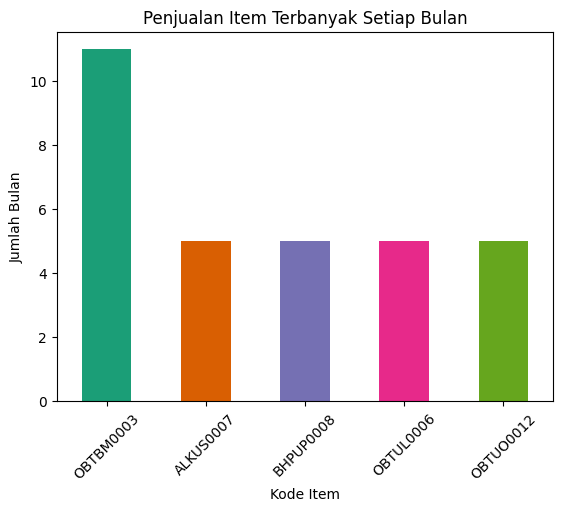

In [ ]:
#visualisasi data
most_selling_items.groupby('Kode Item').size().sort_values(ascending=False).head(5).plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
# plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xticks(rotation=45)
plt.ylabel('Jumlah Bulan')
plt.title('Penjualan Item Terbanyak Setiap Bulan')

# item yang di forecast OBTBM0003, ALKUS0007, BHPUP0008, OBTUL0006, OBTUO0012

In [ ]:
# Pengelompokan data perbulan untuk kode item OBTBM0003
filtered_data = data_forecast[data_forecast['Kode Item'] == 'OBTUS0061']

# Mengonversi kolom 'Tanggal' ke tipe datetime
filtered_data['Tanggal'] = pd.to_datetime(filtered_data['Tanggal'])
filtered_data.rename(columns = {'Jumlah':'Jumlah_OBTUS0061'}, inplace = True)

# Menambahkan kolom baru 'Bulan' dan 'Tahun' berdasarkan kolom 'Tanggal'
filtered_data['Month_Year'] = filtered_data['Tanggal'].dt.to_period('M')

# Mengelompokkan data berdasarkan bulan dan tahun, kemudian menjumlahkan jumlah item
sales_item_OBTUS0061 = filtered_data.groupby(['Month_Year'])['Jumlah_OBTUS0061'].sum().reset_index()

# Menampilkan total item per bulan
sales_item_OBTUS0061.sort_values(by='Month_Year', ascending=True, ignore_index=True).head(5)


<ipython-input-21-e0453d8bee24>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Tanggal'] = pd.to_datetime(filtered_data['Tanggal'])
<ipython-input-21-e0453d8bee24>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.rename(columns = {'Jumlah':'Jumlah_OBTUS0061'}, inplace = True)
<ipython-input-21-e0453d8bee24>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,Month_Year,Jumlah_OBTUS0061
0,2021-01,11.0
1,2021-02,3.0
2,2021-03,4.0
3,2021-04,2.0
4,2021-05,12.0


In [ ]:
# Pengelompokan data perbulan untuk kode item OBTBM0003
filtered_data = data_forecast[data_forecast['Kode Item'] == 'OBTUD0011']

# Mengonversi kolom 'Tanggal' ke tipe datetime
filtered_data['Tanggal'] = pd.to_datetime(filtered_data['Tanggal'])
filtered_data.rename(columns = {'Jumlah':'Jumlah_OBTUD0011'}, inplace = True)

# Menambahkan kolom baru 'Bulan' dan 'Tahun' berdasarkan kolom 'Tanggal'
filtered_data['Month_Year'] = filtered_data['Tanggal'].dt.to_period('M')

# Mengelompokkan data berdasarkan bulan dan tahun, kemudian menjumlahkan jumlah item
sales_item_OBTUD0011 = filtered_data.groupby(['Month_Year'])['Jumlah_OBTUD0011'].sum().reset_index()

# Menampilkan total item per bulan
sales_item_OBTUD0011.sort_values(by='Month_Year', ascending=True, ignore_index=True).head(5)

<ipython-input-22-16ed7af83179>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Tanggal'] = pd.to_datetime(filtered_data['Tanggal'])
<ipython-input-22-16ed7af83179>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.rename(columns = {'Jumlah':'Jumlah_OBTUD0011'}, inplace = True)
<ipython-input-22-16ed7af83179>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,Month_Year,Jumlah_OBTUD0011
0,2021-01,138.0
1,2021-02,132.0
2,2021-03,156.0
3,2021-04,255.0
4,2021-05,315.0


In [ ]:
# Pengelompokan data perbulan untuk kode item OBTBM0003
filtered_data = data_forecast[data_forecast['Kode Item'] == 'OBTUD0003']

# Mengonversi kolom 'Tanggal' ke tipe datetime
filtered_data['Tanggal'] = pd.to_datetime(filtered_data['Tanggal'])
filtered_data.rename(columns = {'Jumlah':'Jumlah_OBTUD0003'}, inplace = True)

# Menambahkan kolom baru 'Bulan' dan 'Tahun' berdasarkan kolom 'Tanggal'
filtered_data['Month_Year'] = filtered_data['Tanggal'].dt.to_period('M')

# Mengelompokkan data berdasarkan bulan dan tahun, kemudian menjumlahkan jumlah item
sales_item_OBTUD0003 = filtered_data.groupby(['Month_Year'])['Jumlah_OBTUD0003'].sum().reset_index()

# Menampilkan total item per bulan
sales_item_OBTUD0003.sort_values(by='Month_Year', ascending=True, ignore_index=True).head(5)

<ipython-input-23-444f3b3b55b3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Tanggal'] = pd.to_datetime(filtered_data['Tanggal'])
<ipython-input-23-444f3b3b55b3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.rename(columns = {'Jumlah':'Jumlah_OBTUD0003'}, inplace = True)
<ipython-input-23-444f3b3b55b3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,Month_Year,Jumlah_OBTUD0003
0,2021-01,36.0
1,2021-02,36.0
2,2021-03,65.0
3,2021-04,25.0
4,2021-05,56.0


In [ ]:
# Pengelompokan data perbulan untuk kode item OBTBM0003
filtered_data = data_forecast[data_forecast['Kode Item'] == 'OBTUC0114']

# Mengonversi kolom 'Tanggal' ke tipe datetime
filtered_data['Tanggal'] = pd.to_datetime(filtered_data['Tanggal'])
filtered_data.rename(columns = {'Jumlah':'Jumlah_OBTUC0114'}, inplace = True)

# Menambahkan kolom baru 'Bulan' dan 'Tahun' berdasarkan kolom 'Tanggal'
filtered_data['Month_Year'] = filtered_data['Tanggal'].dt.to_period('M')

# Mengelompokkan data berdasarkan bulan dan tahun, kemudian menjumlahkan jumlah item
sales_item_OBTUC0114 = filtered_data.groupby(['Month_Year'])['Jumlah_OBTUC0114'].sum().reset_index()

# Menampilkan total item per bulan
sales_item_OBTUC0114.sort_values(by='Month_Year', ascending=True, ignore_index=True).head(5)

<ipython-input-24-06c70e84c1e9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Tanggal'] = pd.to_datetime(filtered_data['Tanggal'])
<ipython-input-24-06c70e84c1e9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.rename(columns = {'Jumlah':'Jumlah_OBTUC0114'}, inplace = True)
<ipython-input-24-06c70e84c1e9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,Month_Year,Jumlah_OBTUC0114
0,2021-01,650.0
1,2021-02,384.0
2,2021-03,443.0
3,2021-04,398.0
4,2021-05,1057.0


In [ ]:
# Pengelompokan data perbulan untuk kode item OBTBM0003
filtered_data = data_forecast[data_forecast['Kode Item'] == 'OBTUC0121']

# Mengonversi kolom 'Tanggal' ke tipe datetime
filtered_data['Tanggal'] = pd.to_datetime(filtered_data['Tanggal'])
filtered_data.rename(columns = {'Jumlah':'Jumlah_OBTUC0121'}, inplace = True)

# Menambahkan kolom baru 'Bulan' dan 'Tahun' berdasarkan kolom 'Tanggal'
filtered_data['Month_Year'] = filtered_data['Tanggal'].dt.to_period('M')

# Mengelompokkan data berdasarkan bulan dan tahun, kemudian menjumlahkan jumlah item
sales_item_OBTUC0121 = filtered_data.groupby(['Month_Year'])['Jumlah_OBTUC0121'].sum().reset_index()

# Menampilkan total item per bulan
sales_item_OBTUC0121.sort_values(by='Month_Year', ascending=True, ignore_index=True).head(5)

<ipython-input-25-146cacb4dd5d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Tanggal'] = pd.to_datetime(filtered_data['Tanggal'])
<ipython-input-25-146cacb4dd5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.rename(columns = {'Jumlah':'Jumlah_OBTUC0121'}, inplace = True)
<ipython-input-25-146cacb4dd5d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,Month_Year,Jumlah_OBTUC0121
0,2021-01,92.0
1,2021-02,134.0
2,2021-03,66.0
3,2021-04,120.0
4,2021-05,259.0


In [ ]:
marged_sales_data = pd.merge(sales_item_OBTUS0061, sales_item_OBTUD0011, on='Month_Year')
marged_sales_data = pd.merge(marged_sales_data, sales_item_OBTUD0003, on='Month_Year')
marged_sales_data = pd.merge(marged_sales_data, sales_item_OBTUC0114, on='Month_Year')
marged_sales_data = pd.merge(marged_sales_data, sales_item_OBTUC0121, on='Month_Year')

marged_sales_data.head(5)

,Month_Year,Jumlah_OBTUS0061,Jumlah_OBTUD0011,Jumlah_OBTUD0003,Jumlah_OBTUC0114,Jumlah_OBTUC0121
0,2021-01,11.0,138.0,36.0,650.0,92.0
1,2021-02,3.0,132.0,36.0,384.0,134.0
2,2021-03,4.0,156.0,65.0,443.0,66.0
3,2021-04,2.0,255.0,25.0,398.0,120.0
4,2021-05,12.0,315.0,56.0,1057.0,259.0


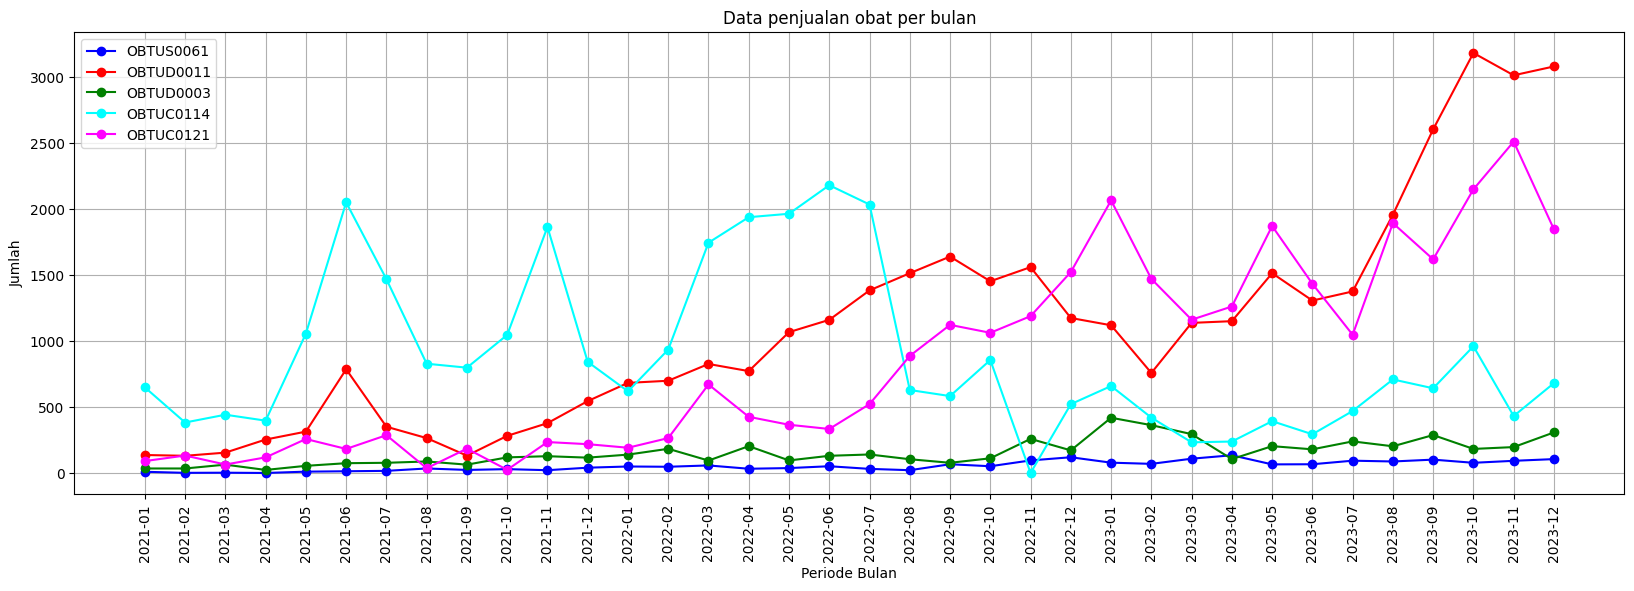

In [ ]:
# # Example of creating a period column
# total_per_month['period[M]'] = pd.PeriodIndex(total_per_month['Month_Year'], freq='M')

# # Extract start date of each period and convert to datetime
# total_per_month['Period_Start_Date'] = total_per_month['period[M]'].dt.to_timestamp()
marged_sales_data['Month_Year'] = marged_sales_data['Month_Year'].astype(str)

# Create line plot
plt.figure(figsize=(20, 6))
plt.plot(marged_sales_data['Month_Year'], marged_sales_data['Jumlah_OBTUS0061'], marker='o', color='blue', linestyle='-', label='OBTUS0061')
plt.plot(marged_sales_data['Month_Year'], marged_sales_data['Jumlah_OBTUD0011'], marker='o', color='red', linestyle='-', label='OBTUD0011')
plt.plot(marged_sales_data['Month_Year'], marged_sales_data['Jumlah_OBTUD0003'], marker='o', color='green', linestyle='-', label='OBTUD0003')
plt.plot(marged_sales_data['Month_Year'], marged_sales_data['Jumlah_OBTUC0114'], marker='o', color='cyan', linestyle='-', label='OBTUC0114')
plt.plot(marged_sales_data['Month_Year'], marged_sales_data['Jumlah_OBTUC0121'], marker='o', color='magenta', linestyle='-', label='OBTUC0121')
plt.title('Data penjualan obat per bulan')
plt.xlabel('Periode Bulan')
plt.ylabel('Jumlah')
plt.legend()
plt.grid(True)


# # Add annotations for each data point
# for i, row in marged_sales_data.iterrows():
#     plt.text(row['Month_Year'], row['Jumlah_OBTUS0061'], row['Jumlah_OBTUS0061'], fontsize=9, ha='right')

# for i, row in marged_sales_data.iterrows():
#     plt.text(row['Month_Year'], row['Jumlah_OBTUD0011'], row['Jumlah_OBTUD0011'], fontsize=9, ha='right')

plt.xticks(rotation=90)
plt.show()


#tambah header
#digabung untukbeberapa obat (untuk menunjukan priority)

In [ ]:
#read dataset_clean untuk proses data mingguan
data_forecast_weekly = pd.read_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/dataset_clean.csv')

data_forecast_weekly.head()

,Tanggal,Gudang,Kode Item,NamaItem,Jumlah
0,2021-01-01,5. DEPO FARMASI - RAWAT INAP,OBTUL0039,LOVENOX 20 MG/0.2 ML SYRINGES INJ,2.0
1,2021-01-01,3. DEPO FARMASI - IGD,ALKUS0050,SPALK ANAK 10 CM,1.0
2,2021-01-01,3. DEPO FARMASI - IGD,ALKUI0007,I.V CATHETER NO 24 G ABBOCATH (VASOFIX),1.0
3,2021-01-01,3. DEPO FARMASI - IGD,ALKUI0015,INFUSION SET FOR INFUSION PUMP (ONEMED),1.0
4,2021-01-01,3. DEPO FARMASI - IGD,ALKUT0020,THREEWAY STOP COCK + TUBING (HOSPITECH),1.0


In [ ]:
# data per Minggu
# Convert 'Tanggal' column to datetime if it's not already in datetime format
data_forecast_weekly['Tanggal'] = pd.to_datetime(data_forecast_weekly['Tanggal'])
data_forecast_weekly['Tanggal'] = data_forecast_weekly['Tanggal'].dt.to_period('W')
new_order = ['Tanggal','Kode Item','NamaItem','Jumlah']
data_forecast_weekly_check = data_forecast_weekly[new_order]
# data_forecast_weekly.head(5)
weekly_sales_per_item = data_forecast_weekly_check.groupby(['Kode Item', 'NamaItem'])['Tanggal'].nunique().reset_index()
weekly_sales_per_item.sort_values(by='Tanggal', ascending=False)

,Kode Item,NamaItem,Tanggal
1135,OBTUC0027,CEFIXIME 200 CAPS,157
271,ALKUF0024,FACE MASK O2 NON REBREATHING DWS (REMEDI),157
1308,OBTUD0042,DOMPERIDONE TAB,157
635,ALKUT0020,THREEWAY STOP COCK + TUBING (HOSPITECH),157
1279,OBTUD0011,DEXAMETHASONE 0.5 MG TAB,157
...,...,...,...
541,ALKUS0062,"SPUIT 1 CC TUB ONEMED, Box/100",1
549,ALKUS0066,"SPUIT 3 CC ONEMED, Box/100",1
2059,OBTUP0073,"PULMICORT 0,25 RESP (0.5 MG/2 ML)",1
560,ALKUS0076,STIMUPLEX A 22GX2 (0.70X50MM),1


from matplotlib import pyplot as plt
_df_0['Tanggal'].plot(kind='hist', bins=20, title='Tanggal')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Tanggal'].plot(kind='line', figsize=(8, 4), title='Tanggal')
plt.gca().spines[['top', 'right']].set_visible(False)

OBTUC0027
ALKUF0024
OBTUD0042
ALKUT0020
OBTUD0011

In [ ]:
#read dataset_clean untuk proses data mingguan
data_forecast_weekly = pd.read_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/dataset_clean.csv')

data_forecast_weekly.head(5)

,Tanggal,Gudang,Kode Item,NamaItem,Jumlah
0,2021-01-01,5. DEPO FARMASI - RAWAT INAP,OBTUL0039,LOVENOX 20 MG/0.2 ML SYRINGES INJ,2.0
1,2021-01-01,3. DEPO FARMASI - IGD,ALKUS0050,SPALK ANAK 10 CM,1.0
2,2021-01-01,3. DEPO FARMASI - IGD,ALKUI0007,I.V CATHETER NO 24 G ABBOCATH (VASOFIX),1.0
3,2021-01-01,3. DEPO FARMASI - IGD,ALKUI0015,INFUSION SET FOR INFUSION PUMP (ONEMED),1.0
4,2021-01-01,3. DEPO FARMASI - IGD,ALKUT0020,THREEWAY STOP COCK + TUBING (HOSPITECH),1.0


In [ ]:
# data_forecast_weekly
# Pengelompokan data perbulan untuk kode item OBTUC0027
filtered_data = data_forecast_weekly[data_forecast_weekly['Kode Item'] == 'OBTUC0027']

# Mengonversi kolom 'Tanggal' ke tipe datetime
filtered_data['Tanggal'] = pd.to_datetime(filtered_data['Tanggal'])
filtered_data.rename(columns = {'Jumlah':'Jumlah_OBTUC0027'}, inplace = True)

# Menambahkan kolom baru 'Bulan' dan 'Tahun' berdasarkan kolom 'Tanggal'
filtered_data['Week'] = filtered_data['Tanggal'].dt.to_period('W')

# Mengelompokkan data berdasarkan bulan dan tahun, kemudian menjumlahkan jumlah item
sales_item_weekly_OBTUC0027 = filtered_data.groupby(['Week'])['Jumlah_OBTUC0027'].sum().reset_index()

# Menampilkan total item per bulan
sales_item_weekly_OBTUC0027.sort_values(by='Week', ascending=True, ignore_index=True).tail(5)

<ipython-input-4-a3ffafac3a78>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Tanggal'] = pd.to_datetime(filtered_data['Tanggal'])
<ipython-input-4-a3ffafac3a78>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.rename(columns = {'Jumlah':'Jumlah_OBTUC0027'}, inplace = True)
<ipython-input-4-a3ffafac3a78>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

,Week,Jumlah_OBTUC0027
152,2023-11-27/2023-12-03,358.0
153,2023-12-04/2023-12-10,265.0
154,2023-12-11/2023-12-17,282.0
155,2023-12-18/2023-12-24,373.0
156,2023-12-25/2023-12-31,283.0


In [ ]:
# Pengelompokan data perbulan untuk kode item ALKUF0024
filtered_data = data_forecast_weekly[data_forecast_weekly['Kode Item'] == 'ALKUF0024']

# Mengonversi kolom 'Tanggal' ke tipe datetime
filtered_data['Tanggal'] = pd.to_datetime(filtered_data['Tanggal'])
filtered_data.rename(columns = {'Jumlah':'Jumlah_ALKUF0024'}, inplace = True)

# Menambahkan kolom baru 'Bulan' dan 'Tahun' berdasarkan kolom 'Tanggal'
filtered_data['Week'] = filtered_data['Tanggal'].dt.to_period('W')

# Mengelompokkan data berdasarkan bulan dan tahun, kemudian menjumlahkan jumlah item
sales_item_weekly_ALKUF0024 = filtered_data.groupby(['Week'])['Jumlah_ALKUF0024'].sum().reset_index()

# Menampilkan total item per bulan
sales_item_weekly_ALKUF0024.sort_values(by='Week', ascending=True, ignore_index=True).tail(5)

<ipython-input-5-086f5f95a0b5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Tanggal'] = pd.to_datetime(filtered_data['Tanggal'])
<ipython-input-5-086f5f95a0b5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.rename(columns = {'Jumlah':'Jumlah_ALKUF0024'}, inplace = True)
<ipython-input-5-086f5f95a0b5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,Week,Jumlah_ALKUF0024
152,2023-11-27/2023-12-03,6.0
153,2023-12-04/2023-12-10,4.0
154,2023-12-11/2023-12-17,4.0
155,2023-12-18/2023-12-24,5.0
156,2023-12-25/2023-12-31,4.0


In [ ]:
# Pengelompokan data perbulan untuk kode item OBTUD0042
filtered_data = data_forecast_weekly[data_forecast_weekly['Kode Item'] == 'OBTUD0042']

# Mengonversi kolom 'Tanggal' ke tipe datetime
filtered_data['Tanggal'] = pd.to_datetime(filtered_data['Tanggal'])
filtered_data.rename(columns = {'Jumlah':'Jumlah_OBTUD0042'}, inplace = True)

# Menambahkan kolom baru 'Bulan' dan 'Tahun' berdasarkan kolom 'Tanggal'
filtered_data['Week'] = filtered_data['Tanggal'].dt.to_period('W')

# Mengelompokkan data berdasarkan bulan dan tahun, kemudian menjumlahkan jumlah item
sales_item_weekly_OBTUD0042 = filtered_data.groupby(['Week'])['Jumlah_OBTUD0042'].sum().reset_index()

# Menampilkan total item per bulan
sales_item_weekly_OBTUD0042.sort_values(by='Week', ascending=True, ignore_index=True).tail(5)

<ipython-input-6-b91e0cd344bd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Tanggal'] = pd.to_datetime(filtered_data['Tanggal'])
<ipython-input-6-b91e0cd344bd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.rename(columns = {'Jumlah':'Jumlah_OBTUD0042'}, inplace = True)
<ipython-input-6-b91e0cd344bd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,Week,Jumlah_OBTUD0042
152,2023-11-27/2023-12-03,336.0
153,2023-12-04/2023-12-10,119.0
154,2023-12-11/2023-12-17,317.0
155,2023-12-18/2023-12-24,289.0
156,2023-12-25/2023-12-31,133.0


In [ ]:
# Pengelompokan data perbulan untuk kode item ALKUT0020
filtered_data = data_forecast_weekly[data_forecast_weekly['Kode Item'] == 'ALKUT0020']

# Mengonversi kolom 'Tanggal' ke tipe datetime
filtered_data['Tanggal'] = pd.to_datetime(filtered_data['Tanggal'])
filtered_data.rename(columns = {'Jumlah':'Jumlah_ALKUT0020'}, inplace = True)

# Menambahkan kolom baru 'Bulan' dan 'Tahun' berdasarkan kolom 'Tanggal'
filtered_data['Week'] = filtered_data['Tanggal'].dt.to_period('W')

# Mengelompokkan data berdasarkan bulan dan tahun, kemudian menjumlahkan jumlah item
sales_item_weekly_ALKUT0020 = filtered_data.groupby(['Week'])['Jumlah_ALKUT0020'].sum().reset_index()

# Menampilkan total item per bulan
sales_item_weekly_ALKUT0020.sort_values(by='Week', ascending=True, ignore_index=True).tail(5)

<ipython-input-7-bd8cb35d5799>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Tanggal'] = pd.to_datetime(filtered_data['Tanggal'])
<ipython-input-7-bd8cb35d5799>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.rename(columns = {'Jumlah':'Jumlah_ALKUT0020'}, inplace = True)
<ipython-input-7-bd8cb35d5799>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,Week,Jumlah_ALKUT0020
152,2023-11-27/2023-12-03,110.0
153,2023-12-04/2023-12-10,75.0
154,2023-12-11/2023-12-17,102.0
155,2023-12-18/2023-12-24,82.0
156,2023-12-25/2023-12-31,75.0


In [ ]:
# Pengelompokan data perbulan untuk kode item OBTUD0011
filtered_data = data_forecast_weekly[data_forecast_weekly['Kode Item'] == 'OBTUD0011']

# Mengonversi kolom 'Tanggal' ke tipe datetime
filtered_data['Tanggal'] = pd.to_datetime(filtered_data['Tanggal'])
filtered_data.rename(columns = {'Jumlah':'Jumlah_OBTUD0011'}, inplace = True)

# Menambahkan kolom baru 'Bulan' dan 'Tahun' berdasarkan kolom 'Tanggal'
filtered_data['Week'] = filtered_data['Tanggal'].dt.to_period('W')

# Mengelompokkan data berdasarkan bulan dan tahun, kemudian menjumlahkan jumlah item
sales_item_weekly_OBTUD0011 = filtered_data.groupby(['Week'])['Jumlah_OBTUD0011'].sum().reset_index()

# Menampilkan total item per bulan
sales_item_weekly_OBTUD0011.sort_values(by='Week', ascending=True, ignore_index=True).tail(5)

<ipython-input-8-b543bc7f1439>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Tanggal'] = pd.to_datetime(filtered_data['Tanggal'])
<ipython-input-8-b543bc7f1439>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.rename(columns = {'Jumlah':'Jumlah_OBTUD0011'}, inplace = True)
<ipython-input-8-b543bc7f1439>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,Week,Jumlah_OBTUD0011
152,2023-11-27/2023-12-03,641.0
153,2023-12-04/2023-12-10,606.0
154,2023-12-11/2023-12-17,737.0
155,2023-12-18/2023-12-24,853.0
156,2023-12-25/2023-12-31,757.0


In [ ]:
marged_sales_data_weekly = pd.merge(sales_item_weekly_OBTUC0027, sales_item_weekly_ALKUF0024, on='Week')
marged_sales_data_weekly = pd.merge(marged_sales_data_weekly, sales_item_weekly_OBTUD0042, on='Week')
marged_sales_data_weekly = pd.merge(marged_sales_data_weekly, sales_item_weekly_ALKUT0020, on='Week')
marged_sales_data_weekly = pd.merge(marged_sales_data_weekly, sales_item_weekly_OBTUD0011, on='Week')

marged_sales_data_weekly #OBTUC0027 ALKUF0024 OBTUD0042 ALKUT0020 OBTUD0011


,Week,Jumlah_OBTUC0027,Jumlah_ALKUF0024,Jumlah_OBTUD0042,Jumlah_ALKUT0020,Jumlah_OBTUD0011
0,2020-12-28/2021-01-03,80.0,3.0,30.0,12.0,14.0
1,2021-01-04/2021-01-10,44.0,5.0,120.0,6.0,36.0
2,2021-01-11/2021-01-17,84.0,5.0,45.0,11.0,44.0
3,2021-01-18/2021-01-24,62.0,13.0,116.0,10.0,14.0
4,2021-01-25/2021-01-31,56.0,8.0,10.0,10.0,30.0
...,...,...,...,...,...,...
152,2023-11-27/2023-12-03,358.0,6.0,336.0,110.0,641.0
153,2023-12-04/2023-12-10,265.0,4.0,119.0,75.0,606.0
154,2023-12-11/2023-12-17,282.0,4.0,317.0,102.0,737.0
155,2023-12-18/2023-12-24,373.0,5.0,289.0,82.0,853.0


In [ ]:
marged_sales_data_weekly
marged_sales_data_weekly.to_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/marged_sales_data_weekly.csv', index=False)

In [ ]:
marged_sales_data_weekly_plot = pd.read_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/marged_sales_data_weekly.csv')
marged_sales_data_weekly_plot.head()

,Week,Jumlah_OBTUC0027,Jumlah_ALKUF0024,Jumlah_OBTUD0042,Jumlah_ALKUT0020,Jumlah_OBTUD0011
0,2020-12-28/2021-01-03,80.0,3.0,30.0,12.0,14.0
1,2021-01-04/2021-01-10,44.0,5.0,120.0,6.0,36.0
2,2021-01-11/2021-01-17,84.0,5.0,45.0,11.0,44.0
3,2021-01-18/2021-01-24,62.0,13.0,116.0,10.0,14.0
4,2021-01-25/2021-01-31,56.0,8.0,10.0,10.0,30.0


In [ ]:
# Selecting the last element from the resulting lists
marged_sales_data_weekly_plot['Week'] = marged_sales_data_weekly_plot['Week'].str.split('/')

marged_sales_data_weekly_plot['Week'] = marged_sales_data_weekly_plot['Week'].apply(lambda x: x[-1])

marged_sales_data_weekly_plot['Week'] = pd.to_datetime(marged_sales_data_weekly_plot['Week'])

marged_sales_data_weekly_plot.head()

,Week,Jumlah_OBTUC0027,Jumlah_ALKUF0024,Jumlah_OBTUD0042,Jumlah_ALKUT0020,Jumlah_OBTUD0011
0,2021-01-03,80.0,3.0,30.0,12.0,14.0
1,2021-01-10,44.0,5.0,120.0,6.0,36.0
2,2021-01-17,84.0,5.0,45.0,11.0,44.0
3,2021-01-24,62.0,13.0,116.0,10.0,14.0
4,2021-01-31,56.0,8.0,10.0,10.0,30.0


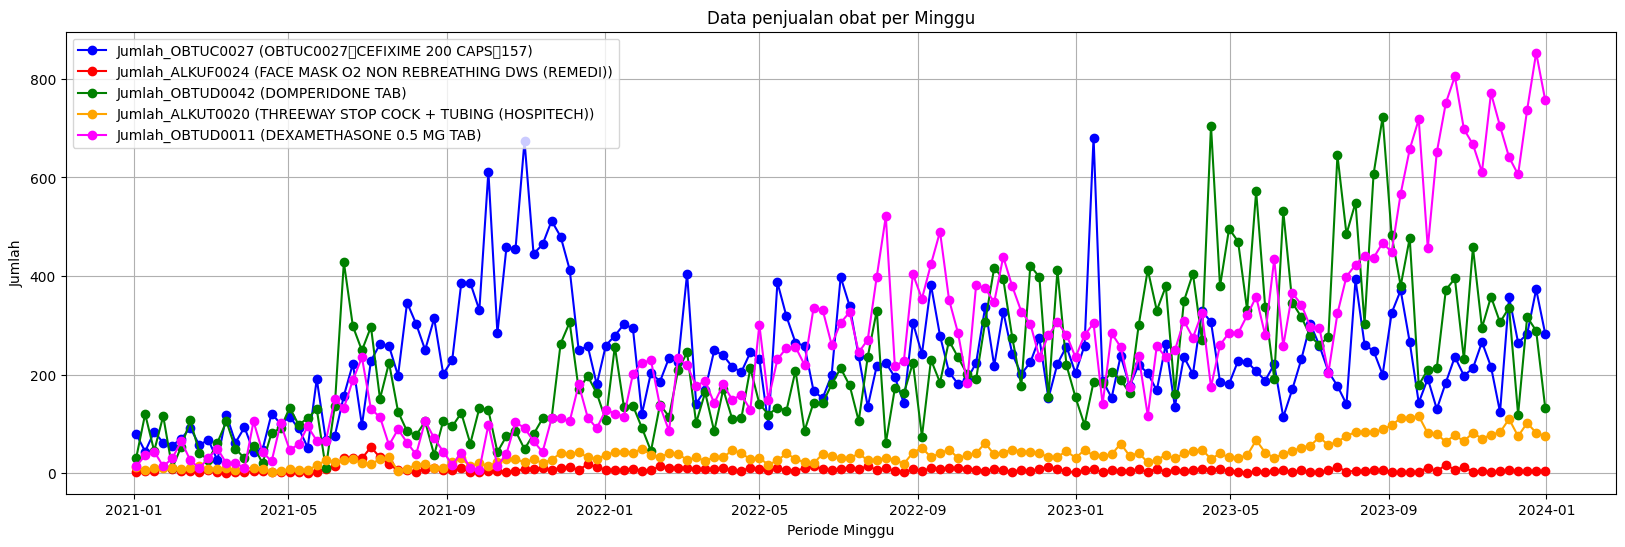

In [ ]:
# sales_item_weekly_OBTUC0121['Week'] = sales_item_weekly_OBTUC0121['Week'].astype(str)

# # Create line plot
# plt.figure(figsize=(20, 6))
# plt.plot(sales_item_weekly_OBTUC0121['Week'], sales_item_weekly_OBTUC0121['Jumlah_OBTUC0121'], marker='o', color='blue', linestyle='-', label='Jumlah_OBTUC0121')
# plt.title('Data penjualan obat per Minggu')
# plt.xlabel('Periode Minggu')
# plt.ylabel('Jumlah')
# plt.legend()
# plt.grid(True)

# # # Add annotations for each data point
# # for i, row in marged_sales_data.iterrows():
# #     plt.text(row['Month_Year'], row['Jumlah_OBTUS0061'], row['Jumlah_OBTUS0061'], fontsize=9, ha='right')

# # for i, row in marged_sales_data.iterrows():
# #     plt.text(row['Month_Year'], row['Jumlah_OBTUD0011'], row['Jumlah_OBTUD0011'], fontsize=9, ha='right')

# plt.xticks(rotation=90)
# plt.show()

# marged_sales_data_weekly_plot_plot['Week'] = marged_sales_data_weekly_plot['Week'].astype(str)

# Create line plot
plt.figure(figsize=(20, 6))
plt.plot(marged_sales_data_weekly_plot['Week'], marged_sales_data_weekly_plot['Jumlah_OBTUC0027'], marker='o', color='blue', linestyle='-', label='Jumlah_OBTUC0027 (OBTUC0027	CEFIXIME 200 CAPS	157)')
plt.plot(marged_sales_data_weekly_plot['Week'], marged_sales_data_weekly_plot['Jumlah_ALKUF0024'], marker='o', color='red', linestyle='-', label='Jumlah_ALKUF0024 (FACE MASK O2 NON REBREATHING DWS (REMEDI))')
plt.plot(marged_sales_data_weekly_plot['Week'], marged_sales_data_weekly_plot['Jumlah_OBTUD0042'], marker='o', color='green', linestyle='-', label='Jumlah_OBTUD0042 (DOMPERIDONE TAB)')
plt.plot(marged_sales_data_weekly_plot['Week'], marged_sales_data_weekly_plot['Jumlah_ALKUT0020'], marker='o', color='orange', linestyle='-', label='Jumlah_ALKUT0020 (THREEWAY STOP COCK + TUBING (HOSPITECH))')
plt.plot(marged_sales_data_weekly_plot['Week'], marged_sales_data_weekly_plot['Jumlah_OBTUD0011'], marker='o', color='magenta', linestyle='-', label='Jumlah_OBTUD0011 (DEXAMETHASONE 0.5 MG TAB)')
plt.title('Data penjualan obat per Minggu')
plt.xlabel('Periode Minggu')
plt.ylabel('Jumlah')
plt.legend()
plt.grid(True)
# # Add annotations for each data point
# for i, row in marged_sales_data.iterrows():
#     plt.text(row['Week'], row['Jumlah_OBTUS0061'], row['Jumlah_OBTUS0061'], fontsize=9, ha='right')

# for i, row in marged_sales_data.iterrows():
#     plt.text(row['Week'], row['Jumlah_OBTUD0011'], row['Jumlah_OBTUD0011'], fontsize=9, ha='right')

# plt.xticks(marged_sales_data_weekly_plot['Week'],rotation=90)
plt.show()

In [ ]:
sales_item_OBTUS0061.to_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_OBTUS0061.csv', index=False)
sales_item_OBTUD0011.to_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_OBTUD0011.csv', index=False)
sales_item_OBTUD0003.to_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_OBTUD0003.csv', index=False)
sales_item_OBTUC0114.to_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_OBTUC0114.csv', index=False)
sales_item_OBTUC0121.to_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_OBTUC0121.csv', index=False)
sales_item_weekly_OBTUC0027.to_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_weekly_OBTUC0027.csv', index=False)
sales_item_weekly_ALKUF0024.to_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_weekly_ALKUF0024.csv', index=False)
sales_item_weekly_OBTUD0042.to_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_weekly_OBTUD0042.csv', index=False)
sales_item_weekly_ALKUT0020.to_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_weekly_ALKUT0020.csv', index=False)
sales_item_weekly_OBTUD0011.to_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_weekly_OBTUD0011.csv', index=False)

# Forecasting ARIMA

In [ ]:
data_set_OBTUC0027 = pd.read_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_weekly_OBTUC0027.csv')
data_set_OBTUC0027.head(5)

,Week,Jumlah_OBTUC0027
0,2020-12-28/2021-01-03,80.0
1,2021-01-04/2021-01-10,44.0
2,2021-01-11/2021-01-17,84.0
3,2021-01-18/2021-01-24,62.0
4,2021-01-25/2021-01-31,56.0


In [ ]:
# Selecting the last element from the resulting lists
data_set_OBTUC0027['Week'] = data_set_OBTUC0027['Week'].str.split('/')

data_set_OBTUC0027['Week'] = data_set_OBTUC0027['Week'].apply(lambda x: x[-1])

data_set_OBTUC0027['Week'] = pd.to_datetime(data_set_OBTUC0027['Week'])

data_set_OBTUC0027.head(5)

,Week,Jumlah_OBTUC0027
0,2021-01-03,80.0
1,2021-01-10,44.0
2,2021-01-17,84.0
3,2021-01-24,62.0
4,2021-01-31,56.0


In [ ]:
#Index the date
data_set_OBTUC0027 = data_set_OBTUC0027.set_index('Week')
data_set_OBTUC0027.index #Lets check the index

DatetimeIndex(['2021-01-03', '2021-01-10', '2021-01-17', '2021-01-24',
               '2021-01-31', '2021-02-07', '2021-02-14', '2021-02-21',
               '2021-02-28', '2021-03-07',
               ...
               '2023-10-29', '2023-11-05', '2023-11-12', '2023-11-19',
               '2023-11-26', '2023-12-03', '2023-12-10', '2023-12-17',
               '2023-12-24', '2023-12-31'],
              dtype='datetime64[ns]', name='Week', length=157, freq=None)

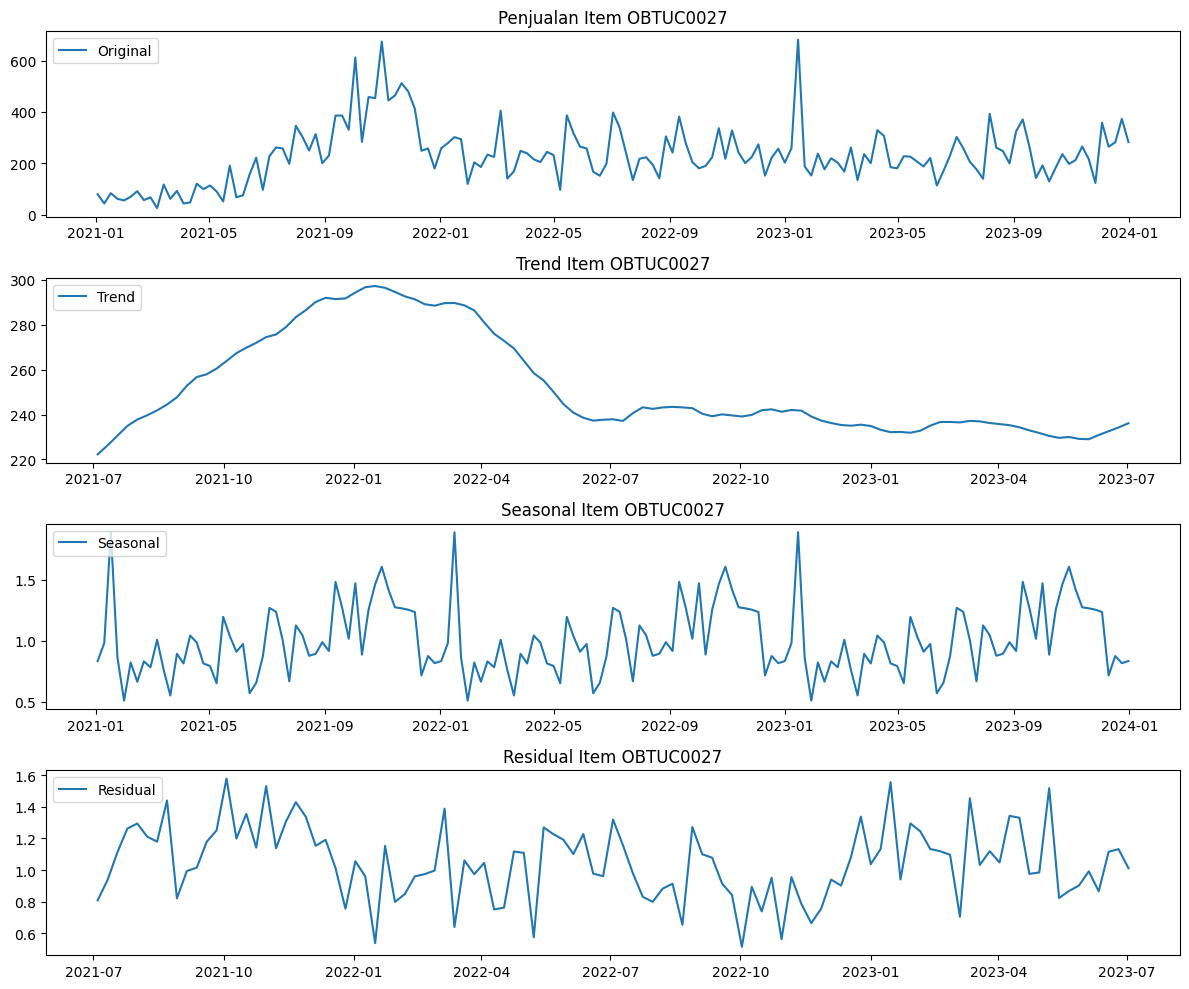

In [ ]:
# melakukan visualisasi dekomposisi musiman
from statsmodels.tsa.seasonal import seasonal_decompose


result = seasonal_decompose(data_set_OBTUC0027['Jumlah_OBTUC0027'],
                            model ='multiplicative')

# Plot the decomposed components with adjusted figure size
plt.figure(figsize=(12, 10))  # Ukuran figure diganti menjadi lebar=12 inch, tinggi=10 inch

# Plot the original time series
plt.subplot(4, 1, 1)
plt.plot(data_set_OBTUC0027.index, data_set_OBTUC0027['Jumlah_OBTUC0027'], label='Original')
plt.title('Penjualan Item OBTUC0027')
plt.legend(loc='upper left')

# Plot the trend component
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.title('Trend Item OBTUC0027')
plt.legend(loc='upper left')

# Plot the seasonal component
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.title('Seasonal Item OBTUC0027')
plt.legend(loc='upper left')

# Plot the residual component
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.title('Residual Item OBTUC0027')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

print(result)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

model = pm.auto_arima(data_set_OBTUC0027.Jumlah_OBTUC0027, start_p=0, start_q=0, start_d=0,
                      information_criterion='aic' ,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, max_d=3, # maximum p and q
                      m=52,             # frequency of series
                      # d=2,           # let model determine 'd'
                      seasonal=True,    # No Seasonality
                      start_P=0,
                      start_D=0, max_D=3,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=1909.381, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=1907.415, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=1875.469, Time=4.88 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=1851.507, Time=5.69 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1905.437, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=1851.168, Time=0.28 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=1851.608, Time=3.53 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=1853.421, Time=9.88 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=1852.990, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : AIC=1852.974, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=1876.381, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=1854.928, Time=1.07 sec
 ARIMA(0,1,1)(0,0,0)[52]             : AIC=1849.609, Time=0.21 sec
 ARIMA(0,1,1)(1,0,0)[52]             : AIC=1850.024, Time=1.20 sec
 ARIMA(0,1,1)(0,0,1

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Split data menjadi set pelatihan dan pengujian
train_OBTUC0027 = data_set_OBTUC0027.iloc[:len(data_set_OBTUC0027)-3]
test_OBTUC0027 = data_set_OBTUC0027.iloc[len(data_set_OBTUC0027)-3:]

# Fitting model ARIMA pada data pelatihan
model = ARIMA(train_OBTUC0027['Jumlah_OBTUC0027'], order=(3, 2, 0))
fit_model = model.fit()

# Melakukan prediksi pada data pengujian
predictions_OBTUC0027 = fit_model.forecast(steps=len(test_OBTUC0027))

# Menampilkan hasil prediksi
print(predictions_OBTUC0027)

# Evaluasi kinerja model
actual_OBTUC0027 = test_OBTUC0027['Jumlah_OBTUC0027']
predicted_OBTUC0027 = predictions_OBTUC0027

def mape(actual_OBTUC0027, predictions):
  abs_error = np.abs(actual_OBTUC0027 - predicted_OBTUC0027)
  rel_error = abs_error / actual_OBTUC0027
  mape = np.mean(rel_error) * 100
  return mape

def rmspe(actual_OBTUC0027, predictions):
  abs_error = np.abs((actual_OBTUC0027 - predicted_OBTUC0027) / actual_OBTUC0027)
  sqrt_error = abs_error ** 2
  mean_sqrt_error = np.mean(sqrt_error)
  rmspe = np.sqrt(mean_sqrt_error) * 100
  return rmspe

result_mape = mape(actual_OBTUC0027, predicted_OBTUC0027)
result_rmspe = rmspe(actual_OBTUC0027, predicted_OBTUC0027)
stddev_actual_OBTUC0027 = np.std(actual_OBTUC0027)
stddev_predicted_OBTUC0027 = np.std(predicted_OBTUC0027, ddof=1)
print(result_mape)
print(result_rmspe)
print('Standar Deviasi Data Aktual', stddev_actual_OBTUC0027)
print('Standar Deviasi Data Prediksi', stddev_predicted_OBTUC0027)

print(test_OBTUC0027)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


2023-12-17    279.340327
2023-12-24    315.467700
2023-12-31    372.588133
Freq: W-SUN, Name: predicted_mean, dtype: float64
16.007979937847598
20.338265102017857
Standar Deviasi Data Aktual 42.66406242052229
Standar Deviasi Data Prediksi 47.01610418770558
            Jumlah_OBTUC0027
Week                        
2023-12-17             282.0
2023-12-24             373.0
2023-12-31             283.0


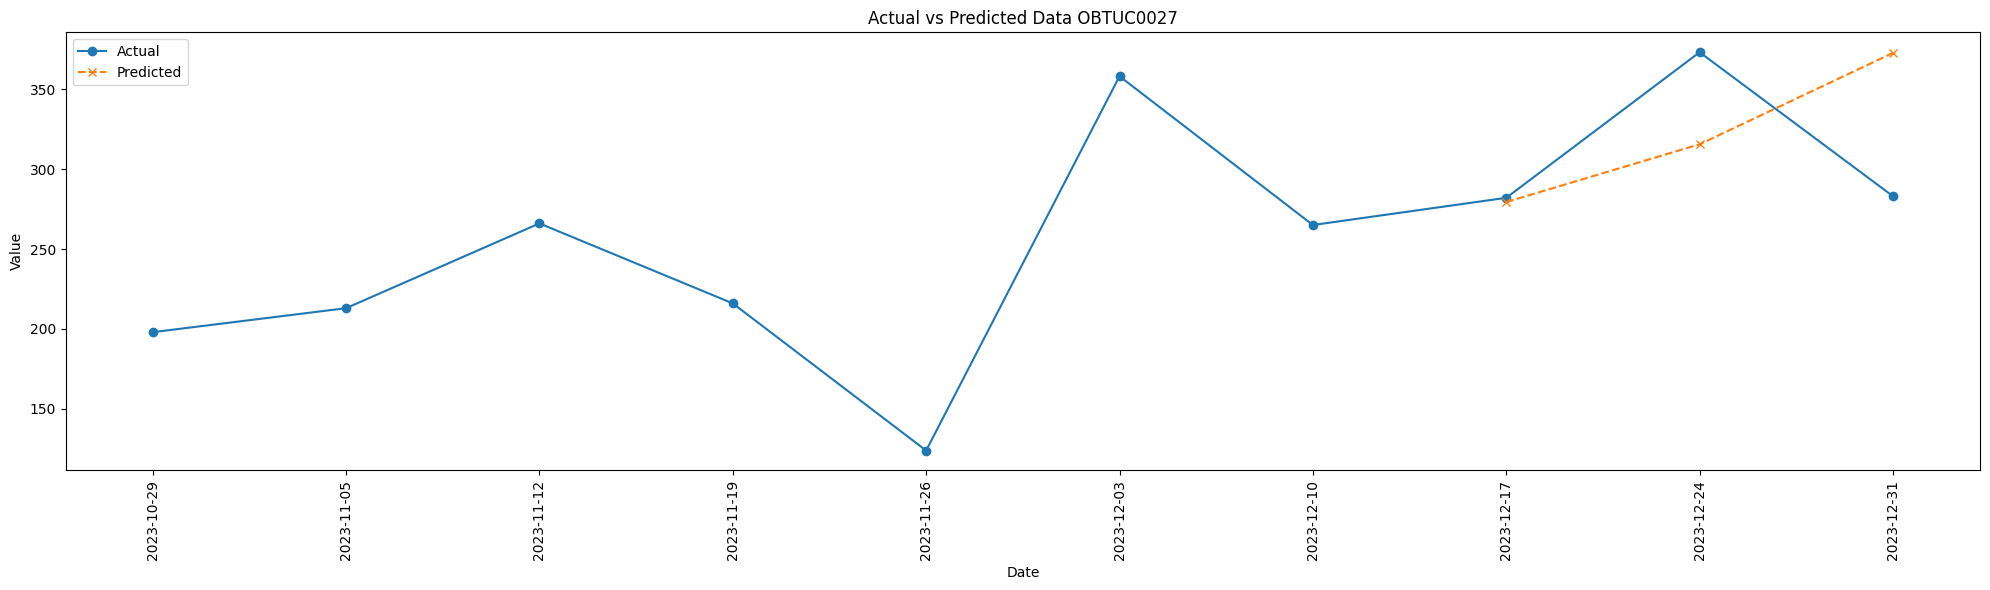

In [ ]:
data_set_actual = pd.read_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_weekly_OBTUC0027.csv').tail(10)

# Selecting the last element from the resulting lists
data_set_actual['Week'] = data_set_actual['Week'].str.split('/')
data_set_actual['Week'] = data_set_actual['Week'].apply(lambda x: x[-1])
data_set_actual['Week'] = pd.to_datetime(data_set_actual['Week'])

data_set_actual
predicted_df = predictions_OBTUC0027

plt.figure(figsize=(20, 6))
plt.plot(data_set_actual['Week'], data_set_actual['Jumlah_OBTUC0027'], linestyle='-',label='Actual', marker='o')
plt.plot(predicted_df.index, predicted_df.values, label='Predicted', linestyle='--', marker='x')
# plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format tanggal sesuai keinginan Anda
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Data OBTUC0027')
plt.xticks(data_set_actual['Week'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
data_set_ALKUF0024 = pd.read_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_weekly_ALKUF0024.csv')
data_set_ALKUF0024.head(5)

,Week,Jumlah_ALKUF0024
0,2020-12-28/2021-01-03,3.0
1,2021-01-04/2021-01-10,5.0
2,2021-01-11/2021-01-17,5.0
3,2021-01-18/2021-01-24,13.0
4,2021-01-25/2021-01-31,8.0


In [ ]:
data_set_ALKUF0024['Week'] = data_set_ALKUF0024['Week'].str.split('/')

# Selecting the last element from the resulting lists
data_set_ALKUF0024['Week'] = data_set_ALKUF0024['Week'].apply(lambda x: x[-1])

data_set_ALKUF0024['Week'] = pd.to_datetime(data_set_ALKUF0024['Week'])

data_set_ALKUF0024.head(5)

,Week,Jumlah_ALKUF0024
0,2021-01-03,3.0
1,2021-01-10,5.0
2,2021-01-17,5.0
3,2021-01-24,13.0
4,2021-01-31,8.0


In [ ]:
#Index the date
data_set_ALKUF0024 = data_set_ALKUF0024.set_index('Week')
data_set_ALKUF0024.index #Lets check the index

DatetimeIndex(['2021-01-03', '2021-01-10', '2021-01-17', '2021-01-24',
               '2021-01-31', '2021-02-07', '2021-02-14', '2021-02-21',
               '2021-02-28', '2021-03-07',
               ...
               '2023-10-29', '2023-11-05', '2023-11-12', '2023-11-19',
               '2023-11-26', '2023-12-03', '2023-12-10', '2023-12-17',
               '2023-12-24', '2023-12-31'],
              dtype='datetime64[ns]', name='Week', length=157, freq=None)

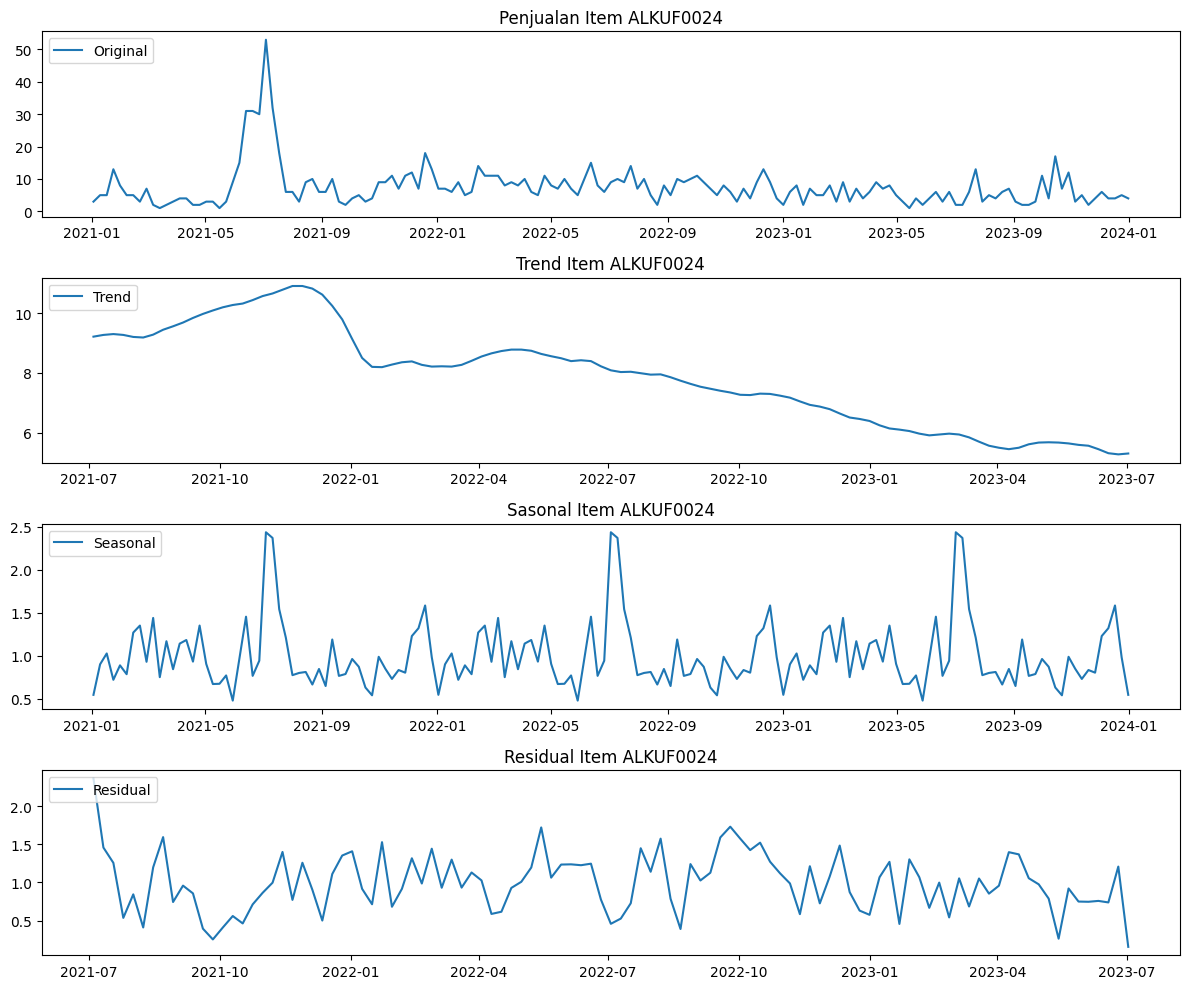

In [ ]:
# melakukan visualisasi dekomposisi musiman
from statsmodels.tsa.seasonal import seasonal_decompose


result = seasonal_decompose(data_set_ALKUF0024['Jumlah_ALKUF0024'],
                            model ='multiplicative')

# Plot the decomposed components with adjusted figure size
plt.figure(figsize=(12, 10))  # Ukuran figure diganti menjadi lebar=12 inch, tinggi=10 inch

# Plot the original time series
plt.subplot(4, 1, 1)
plt.plot(data_set_ALKUF0024.index, data_set_ALKUF0024['Jumlah_ALKUF0024'], label='Original')
plt.title('Penjualan Item ALKUF0024')
plt.legend(loc='upper left')

# Plot the trend component
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.title('Trend Item ALKUF0024')
plt.legend(loc='upper left')

# Plot the seasonal component
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.title('Sasonal Item ALKUF0024')
plt.legend(loc='upper left')

# Plot the residual component
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.title('Residual Item ALKUF0024')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

print(result)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

model = pm.auto_arima(data_set_ALKUF0024.Jumlah_ALKUF0024, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=52,              # frequency of series
                      d=3,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,1)[52]             : AIC=inf, Time=8.06 sec
 ARIMA(0,3,0)(0,0,0)[52]             : AIC=1257.788, Time=0.06 sec
 ARIMA(1,3,0)(1,0,0)[52]             : AIC=1138.916, Time=0.97 sec
 ARIMA(0,3,1)(0,0,1)[52]             : AIC=inf, Time=3.30 sec
 ARIMA(1,3,0)(0,0,0)[52]             : AIC=1139.665, Time=0.05 sec
 ARIMA(1,3,0)(2,0,0)[52]             : AIC=1139.514, Time=7.02 sec
 ARIMA(1,3,0)(1,0,1)[52]             : AIC=inf, Time=3.76 sec
 ARIMA(1,3,0)(0,0,1)[52]             : AIC=1138.260, Time=0.87 sec
 ARIMA(1,3,0)(0,0,2)[52]             : AIC=1139.511, Time=4.64 sec
 ARIMA(1,3,0)(1,0,2)[52]             : AIC=1141.512, Time=9.59 sec
 ARIMA(0,3,0)(0,0,1)[52]             : AIC=1257.475, Time=0.74 sec
 ARIMA(2,3,0)(0,0,1)[52]             : AIC=1080.587, Time=1.12 sec
 ARIMA(2,3,0)(0,0,0)[52]             : AIC=1079.505, Time=0.06 sec
 ARIMA(2,3,0)(1,0,0)[52]             : AIC=1081.005, Time=0.93 sec
 ARIMA(2,3,0)(1,0,1)[52]          

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Split data menjadi set pelatihan dan pengujian
train_ALKUF0024 = data_set_ALKUF0024.iloc[:len(data_set_ALKUF0024)-3]
test_ALKUF0024 = data_set_ALKUF0024.iloc[len(data_set_ALKUF0024)-3:]

# Fitting model ARIMA pada data pelatihan
model = ARIMA(train_ALKUF0024['Jumlah_ALKUF0024'], order=(3, 3, 0))
fit_model = model.fit()

# Melakukan prediksi pada data pengujian
predictions_ALKUF0024 = fit_model.forecast(steps=len(test_ALKUF0024))

# Menampilkan hasil prediksi
print(predictions_ALKUF0024)

# Evaluasi kinerja model
actual_ALKUF0024 = test_ALKUF0024['Jumlah_ALKUF0024']
predicted_ALKUF0024 = predictions_ALKUF0024

def mape(actual_ALKUF0024, predictions):
  abs_error = np.abs(actual_ALKUF0024 - predicted_ALKUF0024)
  rel_error = abs_error / actual_ALKUF0024
  mape = np.mean(rel_error) * 100
  return mape

def rmspe(actual_ALKUF0024, predictions):
  abs_error = np.abs((actual_ALKUF0024 - predicted_ALKUF0024) / actual_ALKUF0024)
  sqrt_error = abs_error ** 2
  mean_sqrt_error = np.mean(sqrt_error)
  rmspe = np.sqrt(mean_sqrt_error) * 100
  return rmspe

result_mape = mape(actual_ALKUF0024, predicted_ALKUF0024)
result_rmspe = rmspe(actual_ALKUF0024, predicted_ALKUF0024)
stddev_predicted_ALKUF0024 = np.std(predicted_ALKUF0024)
print(result_mape)
print(result_rmspe)
print(stddev_predicted_ALKUF0024)
print(test_ALKUF0024)

2023-12-17    4.768490
2023-12-24    5.125560
2023-12-31    4.008203
Freq: W-SUN, Name: predicted_mean, dtype: float64
7.309508276812641
11.187177958531823
0.4659544666457038
            Jumlah_ALKUF0024
Week                        
2023-12-17               4.0
2023-12-24               5.0
2023-12-31               4.0


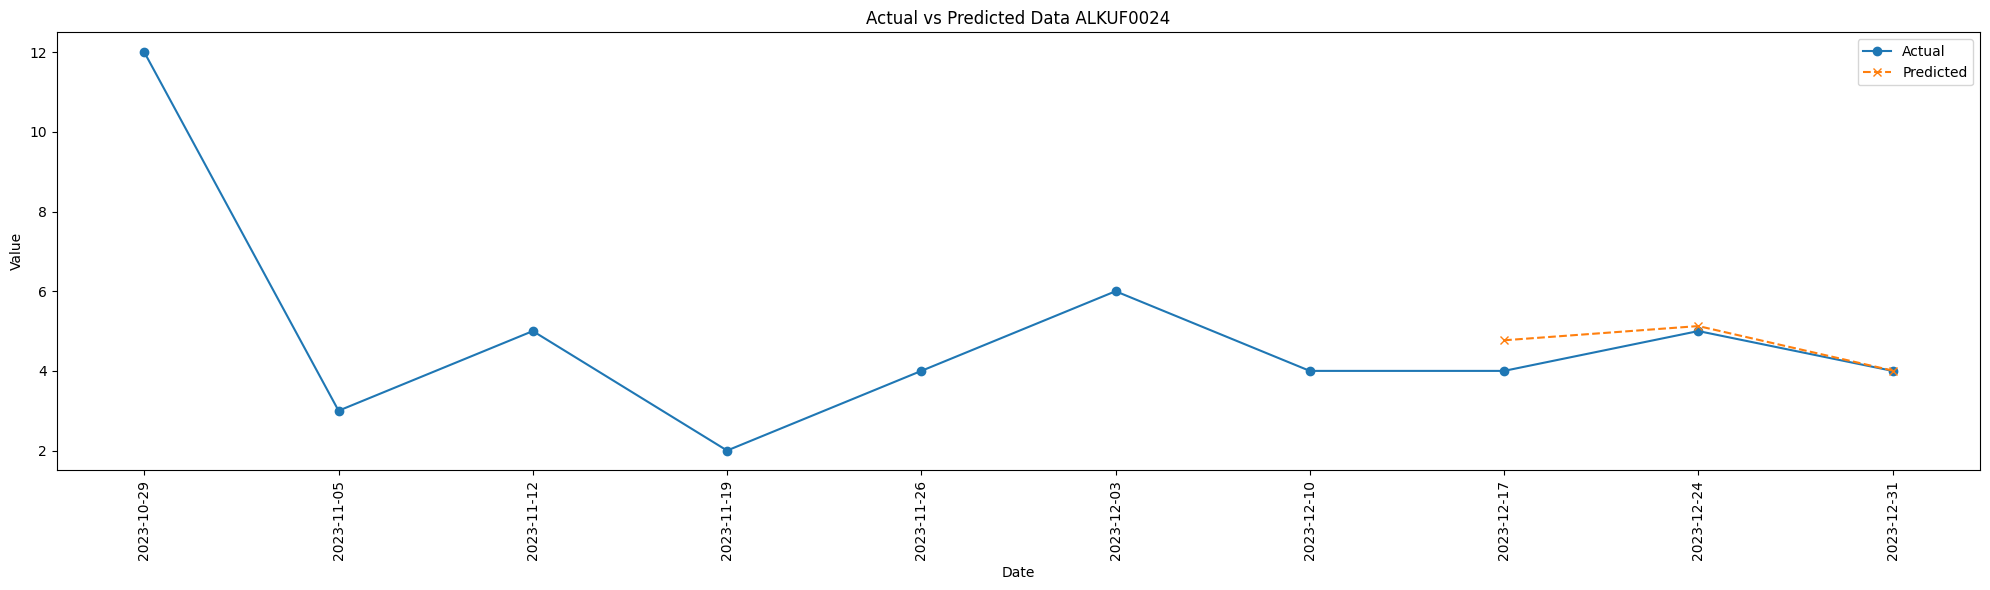

In [ ]:
data_set_actual_ALKUF0024 = pd.read_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_weekly_ALKUF0024.csv').tail(10)
data_set_actual_ALKUF0024['Week'] = data_set_actual_ALKUF0024['Week'].str.split('/')

# Selecting the last element from the resulting lists
data_set_actual_ALKUF0024['Week'] = data_set_actual_ALKUF0024['Week'].apply(lambda x: x[-1])

data_set_actual_ALKUF0024['Week'] = pd.to_datetime(data_set_actual_ALKUF0024['Week'])

data_set_actual_ALKUF0024
predicted_df_ALKUF0024 = predictions_ALKUF0024

# actual_df

plt.figure(figsize=(20, 6))
plt.plot(data_set_actual_ALKUF0024['Week'], data_set_actual_ALKUF0024['Jumlah_ALKUF0024'], linestyle='-',label='Actual', marker='o')
plt.plot(predicted_df_ALKUF0024.index, predicted_df_ALKUF0024.values, label='Predicted', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Data ALKUF0024')
plt.xticks(data_set_actual_ALKUF0024['Week'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
data_set_OBTUD0042 = pd.read_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_weekly_OBTUD0042.csv')
data_set_OBTUD0042.head()

,Week,Jumlah_OBTUD0042
0,2020-12-28/2021-01-03,30.0
1,2021-01-04/2021-01-10,120.0
2,2021-01-11/2021-01-17,45.0
3,2021-01-18/2021-01-24,116.0
4,2021-01-25/2021-01-31,10.0


In [ ]:
# Selecting the last element from the resulting lists
data_set_OBTUD0042['Week'] = data_set_OBTUD0042['Week'].str.split('/')

data_set_OBTUD0042['Week'] = data_set_OBTUD0042['Week'].apply(lambda x: x[-1])

data_set_OBTUD0042['Week'] = pd.to_datetime(data_set_OBTUD0042['Week'])

data_set_OBTUD0042.head()

,Week,Jumlah_OBTUD0042
0,2021-01-03,30.0
1,2021-01-10,120.0
2,2021-01-17,45.0
3,2021-01-24,116.0
4,2021-01-31,10.0


In [ ]:
#Index the date
data_set_OBTUD0042 = data_set_OBTUD0042.set_index('Week')
data_set_OBTUD0042.index #Lets check the index

DatetimeIndex(['2021-01-03', '2021-01-10', '2021-01-17', '2021-01-24',
               '2021-01-31', '2021-02-07', '2021-02-14', '2021-02-21',
               '2021-02-28', '2021-03-07',
               ...
               '2023-10-29', '2023-11-05', '2023-11-12', '2023-11-19',
               '2023-11-26', '2023-12-03', '2023-12-10', '2023-12-17',
               '2023-12-24', '2023-12-31'],
              dtype='datetime64[ns]', name='Week', length=157, freq=None)

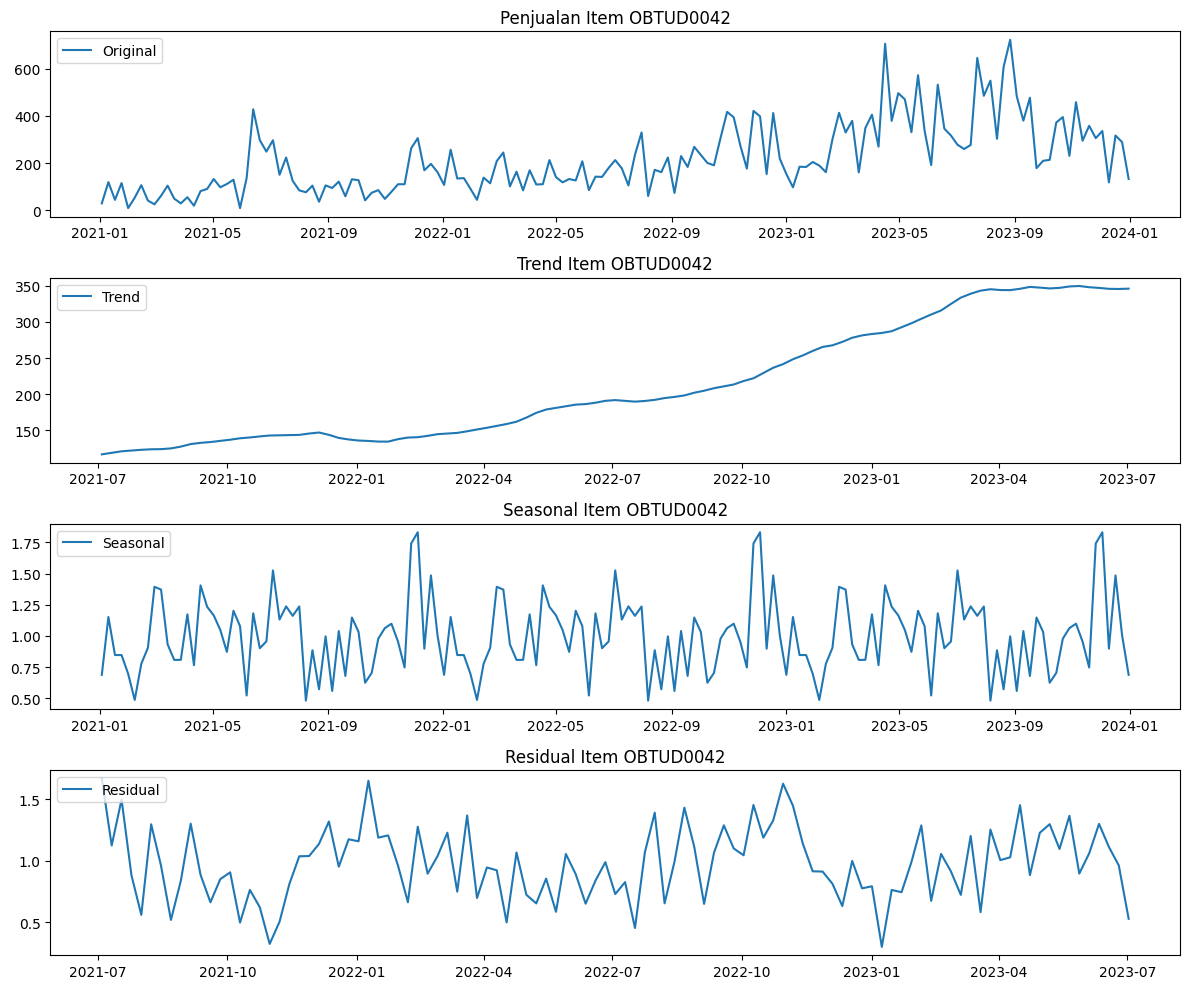

In [ ]:
# melakukan visualisasi dekomposisi musiman
from statsmodels.tsa.seasonal import seasonal_decompose


result = seasonal_decompose(data_set_OBTUD0042['Jumlah_OBTUD0042'],
                            model ='multiplicative')

# Plot the decomposed components with adjusted figure size
plt.figure(figsize=(12, 10))  # Ukuran figure diganti menjadi lebar=12 inch, tinggi=10 inch

# Plot the original time series
plt.subplot(4, 1, 1)
plt.plot(data_set_OBTUD0042.index, data_set_OBTUD0042['Jumlah_OBTUD0042'], label='Original')
plt.title('Penjualan Item OBTUD0042')
plt.legend(loc='upper left')

# Plot the trend component
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.title('Trend Item OBTUD0042')
plt.legend(loc='upper left')

# Plot the seasonal component
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.title('Seasonal Item OBTUD0042')
plt.legend(loc='upper left')

# Plot the residual component
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.title('Residual Item OBTUD0042')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

print(result)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

model = pm.auto_arima(data_set_OBTUD0042.Jumlah_OBTUD0042, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=52,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

# # Fit auto_arima function to dataset
# stepwise_fit = auto_arima(data_set['Jumlah_OBTUD0011'], start_p = 1, start_q = 1,
#                           max_p = 3, max_q = 3, m = 12,
#                           start_P = 0, seasonal = True,
#                           d = None, D = 1, trace = True,
#                           error_action ='ignore',   # we don't want to know if an order does not work
#                           suppress_warnings = True,  # we don't want convergence warnings
#                           stepwise = True)           # set to stepwise

# # To print the summary
# stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=1908.368, Time=7.61 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2016.690, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=1938.180, Time=7.54 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=1973.922, Time=2.42 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2196.587, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=1907.448, Time=0.24 sec
 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=1908.360, Time=5.63 sec
 ARIMA(1,0,1)(1,0,1)[52] intercept   : AIC=inf, Time=9.87 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=1972.006, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=1936.716, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=1909.351, Time=0.35 sec
 ARIMA(1,0,2)(0,0,0)[52] intercept   : AIC=1909.338, Time=0.29 sec
 ARIMA(0,0,2)(0,0,0)[52] intercept   : AIC=1956.890, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=1918.579, Time=0.20 sec
 ARIMA(2,0,2)(0,0,0)[52]

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Split data menjadi set pelatihan dan pengujian
train_OBTUD0042 = data_set_OBTUD0042.iloc[:len(data_set_OBTUD0042)-3]
test_OBTUD0042 = data_set_OBTUD0042.iloc[len(data_set_OBTUD0042)-3:]

# Fitting model ARIMA pada data pelatihan
model = ARIMA(train_OBTUD0042['Jumlah_OBTUD0042'], order=(1, 0, 1))
fit_model = model.fit()

# Melakukan prediksi pada data pengujian
predictions_OBTUD0042 = fit_model.forecast(steps=len(test_OBTUD0042))

# Menampilkan hasil prediksi
print(predictions_OBTUD0042)

# Evaluasi kinerja model
actual_OBTUD0042 = test_OBTUD0042['Jumlah_OBTUD0042']
predicted_OBTUD0042 = predictions_OBTUD0042

def mape(actual_OBTUD0042, predictions):
  abs_error = np.abs(actual_OBTUD0042 - predicted_OBTUD0042)
  rel_error = abs_error / actual_OBTUD0042
  mape = np.mean(rel_error) * 100
  return mape

def rmspe(actual_OBTUD0042, predictions):
  abs_error = np.abs((actual_OBTUD0042 - predicted_OBTUD0042) / actual_OBTUD0042)
  sqrt_error = abs_error ** 2
  mean_sqrt_error = np.mean(sqrt_error)
  rmspe = np.sqrt(mean_sqrt_error) * 100
  return rmspe

result_mape = mape(actual_OBTUD0042, predicted_OBTUD0042)
result_rmspe = rmspe(actual_OBTUD0042, predicted_OBTUD0042)
stddev_predicted_OBTUD0042 = np.std(predicted_OBTUD0042)
print(result_mape)
print(result_rmspe)
print(stddev_predicted_OBTUD0042)
print(test_OBTUD0042)

2023-12-17    248.068484
2023-12-24    246.036152
2023-12-31    244.101523
Freq: W-SUN, Name: predicted_mean, dtype: float64
40.04877352173179
50.56990325555636
1.6196688829923156
            Jumlah_OBTUD0042
Week                        
2023-12-17             317.0
2023-12-24             289.0
2023-12-31             133.0


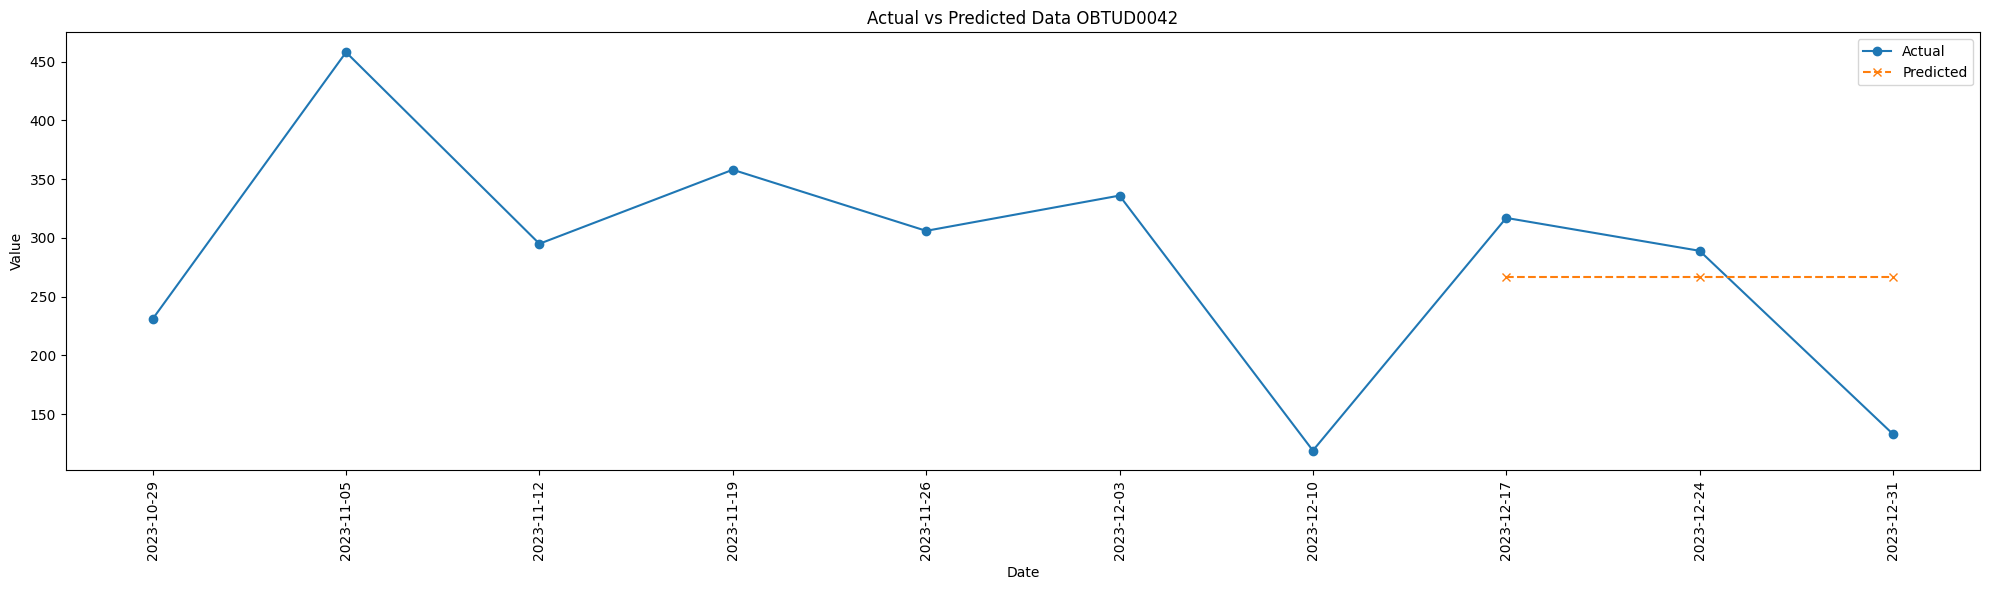

In [ ]:
data_set_actual_OBTUD0042 = pd.read_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_weekly_OBTUD0042.csv').tail(10)

# Selecting the last element from the resulting lists
data_set_actual_OBTUD0042['Week'] = data_set_actual_OBTUD0042['Week'].str.split('/')
data_set_actual_OBTUD0042['Week'] = data_set_actual_OBTUD0042['Week'].apply(lambda x: x[-1])
data_set_actual_OBTUD0042['Week'] = pd.to_datetime(data_set_actual_OBTUD0042['Week'])

data_set_actual_OBTUD0042
predicted_df_OBTUD0042 = predictions_OBTUD0042

# actual_df

plt.figure(figsize=(20, 6))
plt.plot(data_set_actual_OBTUD0042['Week'], data_set_actual_OBTUD0042['Jumlah_OBTUD0042'], linestyle='-',label='Actual', marker='o')
plt.plot(predicted_df_OBTUD0042.index, predicted_df_OBTUD0042.values, label='Predicted', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Data OBTUD0042')
plt.xticks(data_set_actual_OBTUD0042['Week'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
data_set_ALKUT0020 = pd.read_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_weekly_ALKUT0020.csv')
data_set_ALKUT0020.head(5)

,Week,Jumlah_ALKUT0020
0,2020-12-28/2021-01-03,12.0
1,2021-01-04/2021-01-10,6.0
2,2021-01-11/2021-01-17,11.0
3,2021-01-18/2021-01-24,10.0
4,2021-01-25/2021-01-31,10.0


In [ ]:
# Selecting the last element from the resulting lists
data_set_ALKUT0020['Week'] = data_set_ALKUT0020['Week'].str.split('/')

data_set_ALKUT0020['Week'] = data_set_ALKUT0020['Week'].apply(lambda x: x[-1])

data_set_ALKUT0020['Week'] = pd.to_datetime(data_set_ALKUT0020['Week'])

data_set_ALKUT0020.head(5)

,Week,Jumlah_ALKUT0020
0,2021-01-03,12.0
1,2021-01-10,6.0
2,2021-01-17,11.0
3,2021-01-24,10.0
4,2021-01-31,10.0


In [ ]:
#Index the date
data_set_ALKUT0020 = data_set_ALKUT0020.set_index('Week')
data_set_ALKUT0020.index #Lets check the index

DatetimeIndex(['2021-01-03', '2021-01-10', '2021-01-17', '2021-01-24',
               '2021-01-31', '2021-02-07', '2021-02-14', '2021-02-21',
               '2021-02-28', '2021-03-07',
               ...
               '2023-10-29', '2023-11-05', '2023-11-12', '2023-11-19',
               '2023-11-26', '2023-12-03', '2023-12-10', '2023-12-17',
               '2023-12-24', '2023-12-31'],
              dtype='datetime64[ns]', name='Week', length=157, freq=None)

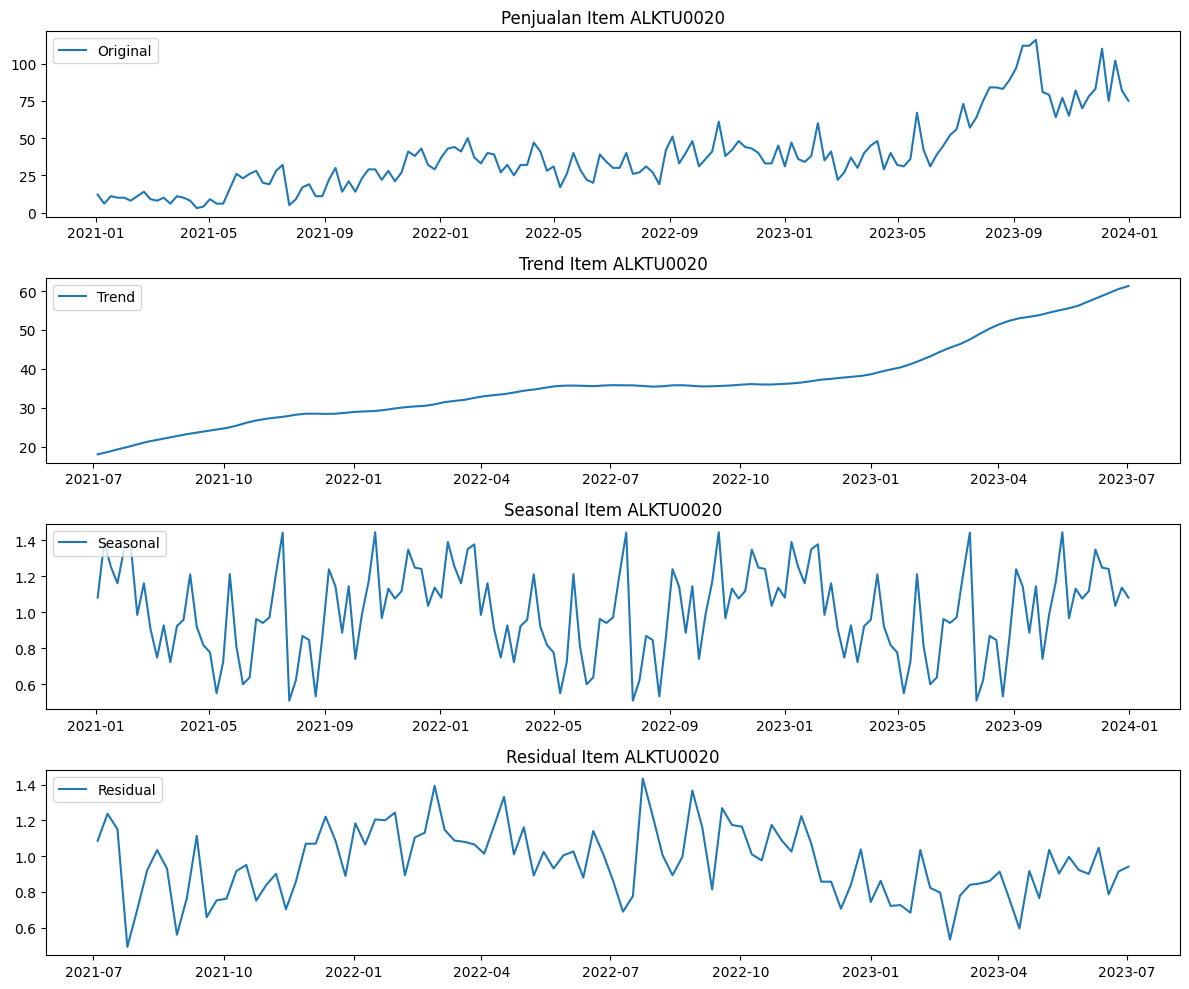

In [ ]:
# melakukan visualisasi dekomposisi musiman
from statsmodels.tsa.seasonal import seasonal_decompose


result = seasonal_decompose(data_set_ALKUT0020['Jumlah_ALKUT0020'],
                            model ='multiplicative')

# Plot the decomposed components with adjusted figure size
plt.figure(figsize=(12, 10))  # Ukuran figure diganti menjadi lebar=12 inch, tinggi=10 inch

# Plot the original time series
plt.subplot(4, 1, 1)
plt.plot(data_set_ALKUT0020.index, data_set_ALKUT0020['Jumlah_ALKUT0020'], label='Original')
plt.title('Penjualan Item ALKTU0020')
plt.legend(loc='upper left')

# Plot the trend component
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.title('Trend Item ALKTU0020')
plt.legend(loc='upper left')

# Plot the seasonal component
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.title('Seasonal Item ALKTU0020')
plt.legend(loc='upper left')

# Plot the residual component
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.title('Residual Item ALKTU0020')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

print(result)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

model = pm.auto_arima(data_set_ALKUT0020.Jumlah_ALKUT0020, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=52,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AIC=1167.117, Time=4.32 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=1197.601, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=1173.881, Time=4.56 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=1166.415, Time=2.65 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1195.807, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=1168.287, Time=0.14 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=1168.268, Time=3.02 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=1168.260, Time=9.73 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=1166.269, Time=1.54 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=1168.268, Time=7.21 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AIC=1170.267, Time=12.58 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=1194.852, Time=1.48 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=1167.063, Time=2.22 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AIC=1167.430, Time=2.80 sec
 ARIMA(1,1,2)(1,0,

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Split data menjadi set pelatihan dan pengujian
train_ALKUT0020 = data_set_ALKUT0020.iloc[:len(data_set_ALKUT0020)-3]
test_ALKUT0020 = data_set_ALKUT0020.iloc[len(data_set_ALKUT0020)-3:]

# Fitting model ARIMA pada data pelatihan
model = ARIMA(train_ALKUT0020['Jumlah_ALKUT0020'], order=(0, 1, 1))
fit_model = model.fit()

# Melakukan prediksi pada data pengujian
predictions_ALKUT0020 = fit_model.forecast(steps=len(test_ALKUT0020))

# Menampilkan hasil prediksi
print(predictions_ALKUT0020)

# Evaluasi kinerja model
actual_ALKUT0020 = test_ALKUT0020['Jumlah_ALKUT0020']
predicted_ALKUT0020 = predictions_ALKUT0020

def mape(actual_ALKUT0020, predictions):
  abs_error = np.abs(actual_ALKUT0020 - predicted_ALKUT0020)
  rel_error = abs_error / actual_ALKUT0020
  mape = np.mean(rel_error) * 100
  return mape

def rmspe(actual_ALKUT0020, predictions):
  abs_error = np.abs((actual_ALKUT0020 - predicted_ALKUT0020) / actual_ALKUT0020)
  sqrt_error = abs_error ** 2
  mean_sqrt_error = np.mean(sqrt_error)
  rmspe = np.sqrt(mean_sqrt_error) * 100
  return rmspe

result_mape = mape(actual_ALKUT0020, predicted_ALKUT0020)
result_rmspe = rmspe(actual_ALKUT0020, predicted_ALKUT0020)
stddev_predicted_ALKUT0020 = np.std(predicted_ALKUT0020)
print(result_mape)
print(result_rmspe)
print(stddev_predicted_ALKUT0020)

2023-12-17    84.795168
2023-12-24    84.795168
2023-12-31    84.795168
Freq: W-SUN, Name: predicted_mean, dtype: float64
11.112149398670557
12.472649179332898
0.0


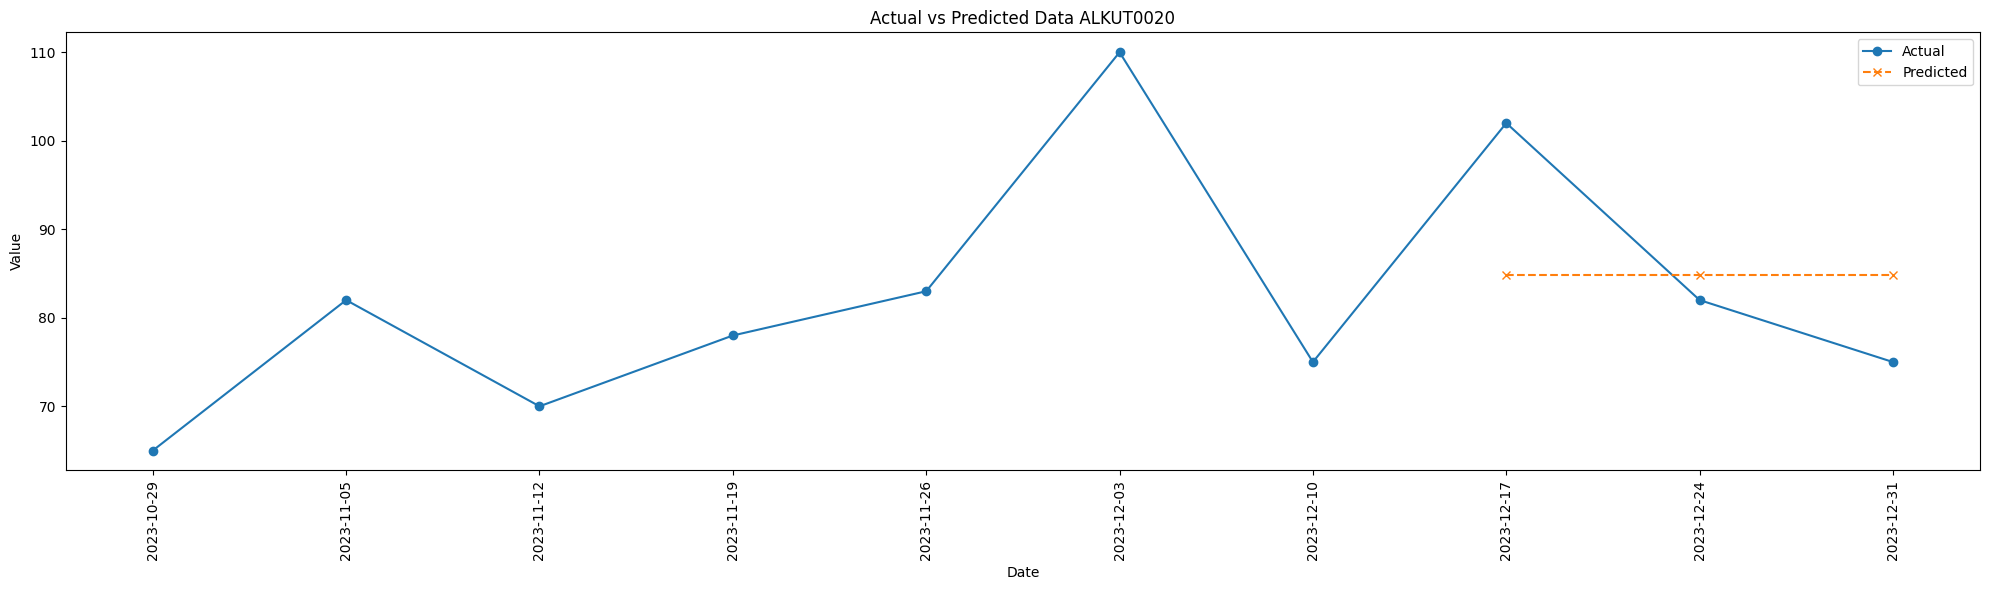

In [ ]:
data_set_actual_ALKUT0020 = pd.read_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_weekly_ALKUT0020.csv').tail(10)

# Selecting the last element from the resulting lists
data_set_actual_ALKUT0020['Week'] = data_set_actual_ALKUT0020['Week'].str.split('/')
data_set_actual_ALKUT0020['Week'] = data_set_actual_ALKUT0020['Week'].apply(lambda x: x[-1])
data_set_actual_ALKUT0020['Week'] = pd.to_datetime(data_set_actual_ALKUT0020['Week'])

data_set_actual_ALKUT0020
predicted_df_ALKUT0020 = predictions_ALKUT0020

plt.figure(figsize=(20, 6))
plt.plot(data_set_actual_ALKUT0020['Week'], data_set_actual_ALKUT0020['Jumlah_ALKUT0020'], linestyle='-',label='Actual', marker='o')
plt.plot(predicted_df_ALKUT0020.index, predicted_df_ALKUT0020.values, label='Predicted', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Data ALKUT0020')
plt.xticks(data_set_actual_ALKUT0020['Week'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
data_set_OBTUD0011 = pd.read_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_weekly_OBTUD0011.csv')
data_set_OBTUD0011.head(5)

,Week,Jumlah_OBTUD0011
0,2020-12-28/2021-01-03,14.0
1,2021-01-04/2021-01-10,36.0
2,2021-01-11/2021-01-17,44.0
3,2021-01-18/2021-01-24,14.0
4,2021-01-25/2021-01-31,30.0


In [ ]:
# Selecting the last element from the resulting lists
data_set_OBTUD0011['Week'] = data_set_OBTUD0011['Week'].str.split('/')

data_set_OBTUD0011['Week'] = data_set_OBTUD0011['Week'].apply(lambda x: x[-1])

data_set_OBTUD0011['Week'] = pd.to_datetime(data_set_OBTUD0011['Week'])

data_set_OBTUD0011.head(5)

,Week,Jumlah_OBTUD0011
0,2021-01-03,14.0
1,2021-01-10,36.0
2,2021-01-17,44.0
3,2021-01-24,14.0
4,2021-01-31,30.0


In [ ]:
#Index the date
data_set_OBTUD0011 = data_set_OBTUD0011.set_index('Week')
data_set_OBTUD0011.index #Lets check the index

DatetimeIndex(['2021-01-03', '2021-01-10', '2021-01-17', '2021-01-24',
               '2021-01-31', '2021-02-07', '2021-02-14', '2021-02-21',
               '2021-02-28', '2021-03-07',
               ...
               '2023-10-29', '2023-11-05', '2023-11-12', '2023-11-19',
               '2023-11-26', '2023-12-03', '2023-12-10', '2023-12-17',
               '2023-12-24', '2023-12-31'],
              dtype='datetime64[ns]', name='Week', length=157, freq=None)

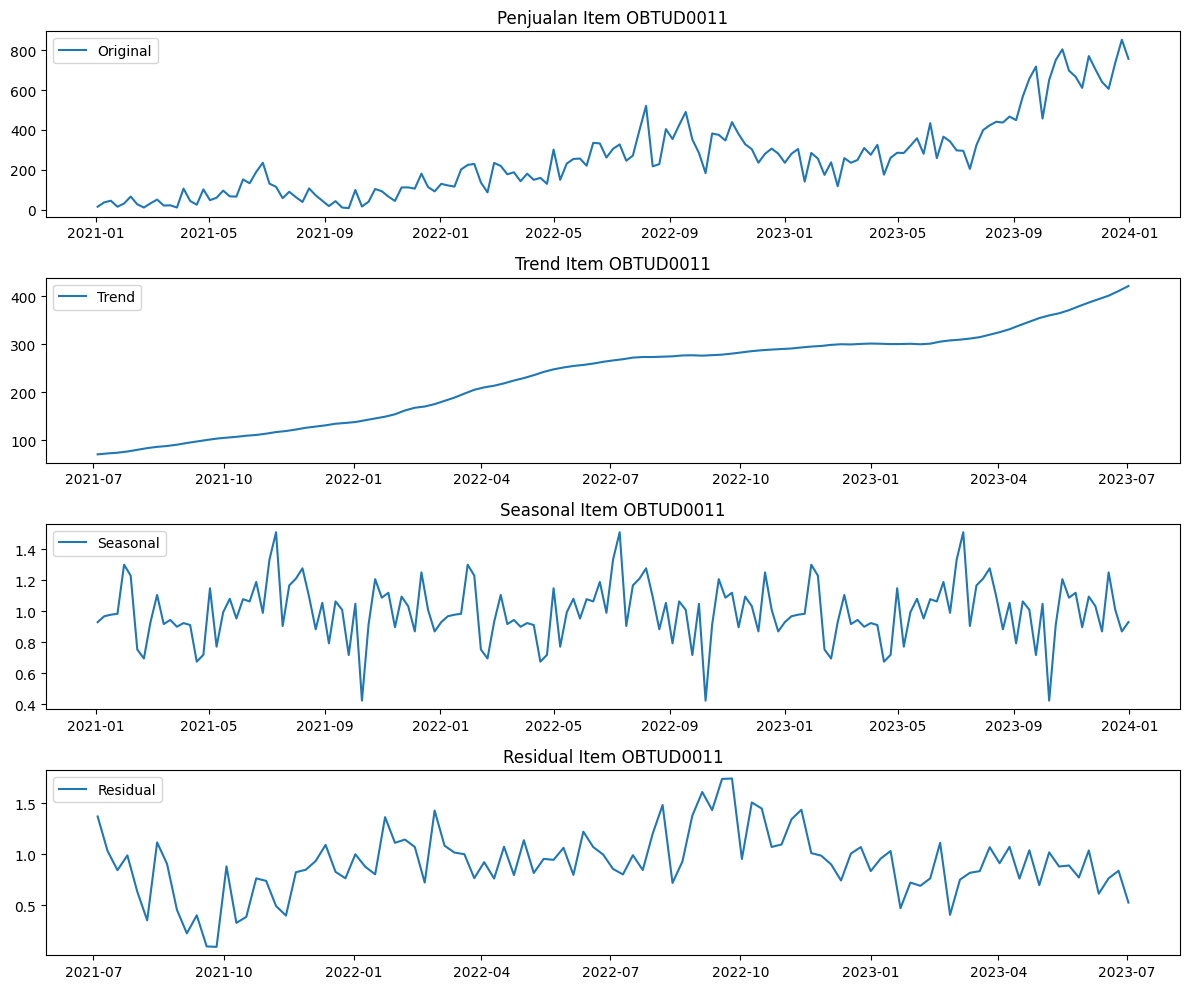

In [ ]:
# melakukan visualisasi dekomposisi musiman
from statsmodels.tsa.seasonal import seasonal_decompose


result = seasonal_decompose(data_set_OBTUD0011['Jumlah_OBTUD0011'],
                            model ='multiplicative')

# Plot the decomposed components with adjusted figure size
plt.figure(figsize=(12, 10))  # Ukuran figure diganti menjadi lebar=12 inch, tinggi=10 inch

# Plot the original time series
plt.subplot(4, 1, 1)
plt.plot(data_set_OBTUD0011.index, data_set_OBTUD0011['Jumlah_OBTUD0011'], label='Original')
plt.title('Penjualan Item OBTUD0011')
plt.legend(loc='upper left')

# Plot the trend component
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.title('Trend Item OBTUD0011')
plt.legend(loc='upper left')

# Plot the seasonal component
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.title('Seasonal Item OBTUD0011')
plt.legend(loc='upper left')

# Plot the residual component
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.title('Residual Item OBTUD0011')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

print(result)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

model = pm.auto_arima(data_set_OBTUD0011.Jumlah_OBTUD0011, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=52,              # frequency of series
                      d=2,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,1)[52]             : AIC=inf, Time=3.34 sec
 ARIMA(0,2,0)(0,0,0)[52]             : AIC=1951.347, Time=0.05 sec
 ARIMA(1,2,0)(1,0,0)[52]             : AIC=1896.402, Time=0.90 sec
 ARIMA(0,2,1)(0,0,1)[52]             : AIC=inf, Time=2.23 sec
 ARIMA(1,2,0)(0,0,0)[52]             : AIC=1894.403, Time=0.05 sec
 ARIMA(1,2,0)(0,0,1)[52]             : AIC=1896.402, Time=1.10 sec
 ARIMA(1,2,0)(1,0,1)[52]             : AIC=1898.398, Time=2.99 sec
 ARIMA(2,2,0)(0,0,0)[52]             : AIC=1857.756, Time=0.18 sec
 ARIMA(2,2,0)(1,0,0)[52]             : AIC=1859.601, Time=2.59 sec
 ARIMA(2,2,0)(0,0,1)[52]             : AIC=1859.606, Time=2.74 sec
 ARIMA(2,2,0)(1,0,1)[52]             : AIC=inf, Time=6.75 sec
 ARIMA(3,2,0)(0,0,0)[52]             : AIC=1835.211, Time=0.10 sec
 ARIMA(3,2,0)(1,0,0)[52]             : AIC=1836.884, Time=1.84 sec
 ARIMA(3,2,0)(0,0,1)[52]             : AIC=1836.901, Time=4.73 sec
 ARIMA(3,2,0)(1,0,1)[52]          

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Split data menjadi set pelatihan dan pengujian
train_OBTUD0011 = data_set_OBTUD0011.iloc[:len(data_set_OBTUD0011)-3]
test_OBTUD0011 = data_set_OBTUD0011.iloc[len(data_set_OBTUD0011)-3:]

# Fitting model ARIMA pada data pelatihan
model = ARIMA(train_OBTUD0011['Jumlah_OBTUD0011'], order=(0, 1, 3))
fit_model = model.fit()

# Melakukan prediksi pada data pengujian
predictions_OBTUD0011 = fit_model.forecast(steps=len(test_OBTUD0011))

# Menampilkan hasil prediksi
print(predictions_OBTUD0011)

# Evaluasi kinerja model
actual_OBTUD0011 = test_OBTUD0011['Jumlah_OBTUD0011']
predicted_OBTUD0011 = predictions_OBTUD0011

def mape(actual_OBTUD0011, predictions):
  abs_error = np.abs(actual_OBTUD0011 - predicted_OBTUD0011)
  rel_error = abs_error / actual_OBTUD0011
  mape = np.mean(rel_error) * 100
  return mape

def rmspe(actual_OBTUD0011, predictions):
  abs_error = np.abs((actual_OBTUD0011 - predicted_OBTUD0011) / actual_OBTUD0011)
  sqrt_error = abs_error ** 2
  mean_sqrt_error = np.mean(sqrt_error)
  rmspe = np.sqrt(mean_sqrt_error) * 100
  return rmspe

result_mape = mape(actual_OBTUD0011, predicted_OBTUD0011)
result_rmspe = rmspe(actual_OBTUD0011, predicted_OBTUD0011)
stddev_predicted_OBTUD0011 = np.std(predicted_OBTUD0011)
print(result_mape)
print(result_rmspe)
print(stddev_predicted_OBTUD0011)

2023-12-17    652.510756
2023-12-24    658.093333
2023-12-31    647.471030
Freq: W-SUN, Name: predicted_mean, dtype: float64
16.260770639181185
16.959468045221975
4.338424238200212


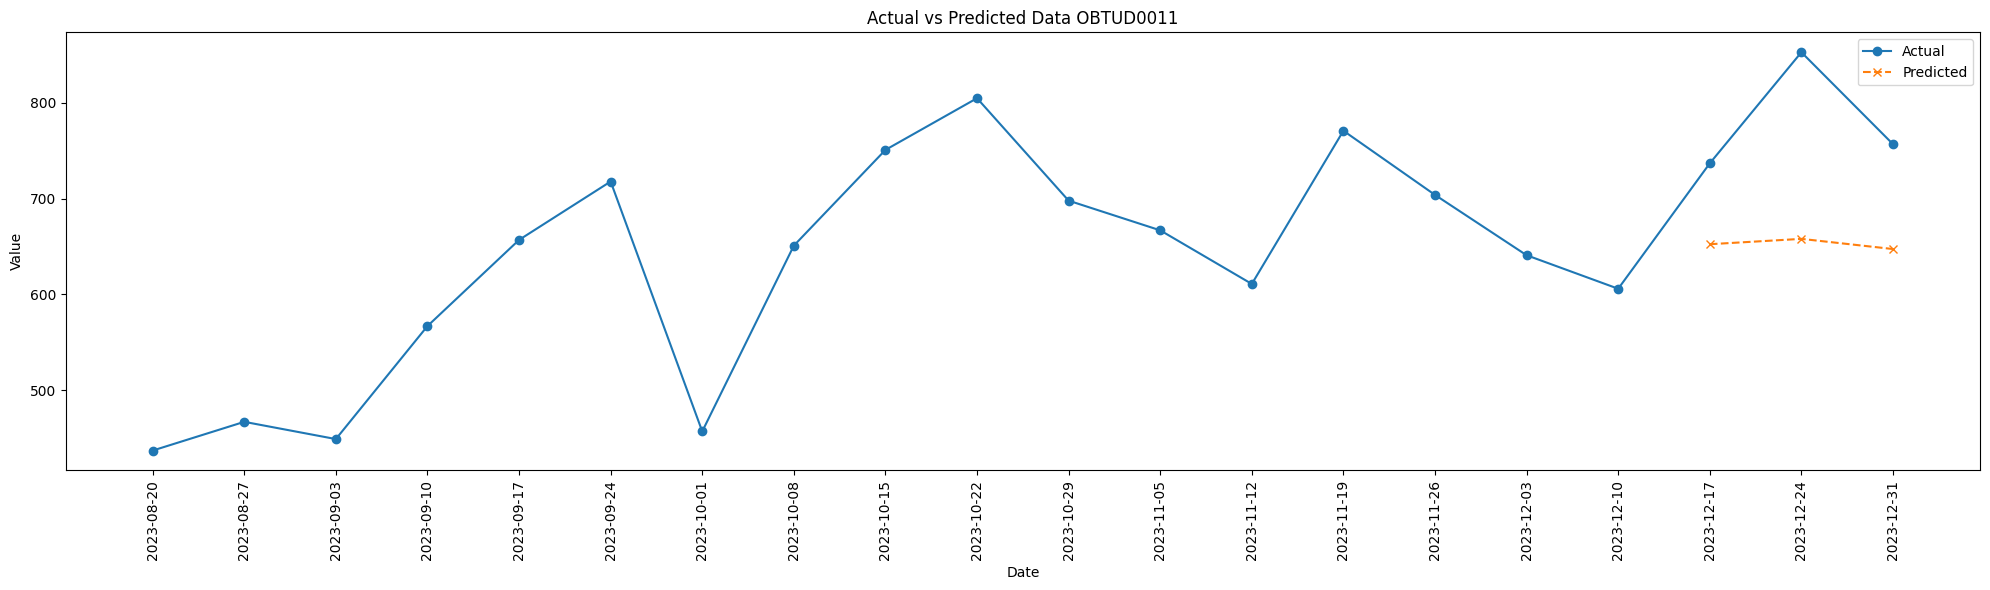

In [ ]:
data_set_actual_OBTUD0011 = pd.read_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_weekly_OBTUD0011.csv').tail(20)

# Selecting the last element from the resulting lists
data_set_actual_OBTUD0011['Week'] = data_set_actual_OBTUD0011['Week'].str.split('/')
data_set_actual_OBTUD0011['Week'] = data_set_actual_OBTUD0011['Week'].apply(lambda x: x[-1])
data_set_actual_OBTUD0011['Week'] = pd.to_datetime(data_set_actual_OBTUD0011['Week'])

data_set_actual_OBTUD0011
predicted_df_OBTUD0011 = predictions_OBTUD0011

# actual_df

plt.figure(figsize=(20, 6))
plt.plot(data_set_actual_OBTUD0011['Week'], data_set_actual_OBTUD0011['Jumlah_OBTUD0011'], linestyle='-',label='Actual', marker='o')
plt.plot(predicted_df_OBTUD0011.index, predicted_df_OBTUD0011.values, label='Predicted', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Data OBTUD0011')
plt.xticks(data_set_actual_OBTUD0011['Week'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Forecasting Prophet

In [ ]:
pr_ds_OBTUC0027 = pd.read_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_weekly_OBTUC0027.csv')
pr_ds_OBTUC0027.head(5)

,Week,Jumlah_OBTUC0027
0,2020-12-28/2021-01-03,80.0
1,2021-01-04/2021-01-10,44.0
2,2021-01-11/2021-01-17,84.0
3,2021-01-18/2021-01-24,62.0
4,2021-01-25/2021-01-31,56.0


In [ ]:
# Selecting the last element from the resulting lists
pr_ds_OBTUC0027['Week'] = pr_ds_OBTUC0027['Week'].str.split('/')

pr_ds_OBTUC0027['Week'] = pr_ds_OBTUC0027['Week'].apply(lambda x: x[-1])

pr_ds_OBTUC0027['Week'] = pd.to_datetime(pr_ds_OBTUC0027['Week'])

pr_ds_OBTUC0027.tail()

,Week,Jumlah_OBTUC0027
152,2023-12-03,358.0
153,2023-12-10,265.0
154,2023-12-17,282.0
155,2023-12-24,373.0
156,2023-12-31,283.0


In [ ]:
pr_ds_OBTUC0027.dtypes

pr_ds_OBTUC0027.rename(columns={'Week': 'ds', 'Jumlah_OBTUC0027': 'y'}, inplace=True)

pr_ds_OBTUC0027

,ds,y
0,2021-01-03,80.0
1,2021-01-10,44.0
2,2021-01-17,84.0
3,2021-01-24,62.0
4,2021-01-31,56.0
...,...,...
152,2023-12-03,358.0
153,2023-12-10,265.0
154,2023-12-17,282.0
155,2023-12-24,373.0


In [ ]:
from prophet import Prophet

m_OBTUC0027 = Prophet(interval_width=0.95, weekly_seasonality=True)
model_OBTUC0027 = m_OBTUC0027.fit(pr_ds_OBTUC0027.tail(3))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvvxiq8eb/da87il29.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvvxiq8eb/0vrz3kkp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48093', 'data', 'file=/tmp/tmpvvxiq8eb/da87il29.json', 'init=/tmp/tmpvvxiq8eb/0vrz3kkp.json', 'output', 'file=/tmp/tmpvvxiq8eb/prophet_model_0zwvose/prophet_model-20240522045529.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:55:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:55:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

In [ ]:
future_OBTUC0027 = m_OBTUC0027.make_future_dataframe(periods=0, freq='W')
forecast_OBTUC0027 = m_OBTUC0027.predict(future_OBTUC0027)
forecast_OBTUC0027 = forecast_OBTUC0027[['ds', 'yhat']]
forecast_OBTUC0027.tail(10)

,ds,yhat
0,2023-12-17,311.972083
1,2023-12-24,312.703346
2,2023-12-31,313.434609


In [ ]:
aktual_OBTUC0027 = pr_ds_OBTUC0027.iloc[len(pr_ds_OBTUC0027)-3:]
prediksi_OBTUC0027 = forecast_OBTUC0027
print('data prediksi',prediksi_OBTUC0027)
print('data aktual',aktual_OBTUC0027)

aktual_OBTUC0027_err = aktual_OBTUC0027['y']
prediksi_OBTUC0027_err = prediksi_OBTUC0027['yhat']

merged_data = pd.merge(prediksi_OBTUC0027, aktual_OBTUC0027, on='ds')
merged_data['abs_pct_error'] = abs((merged_data['y'] - merged_data['yhat']) / merged_data['y']) * 100
mape = merged_data['abs_pct_error'].mean()

merged_data['squared_pct_error'] = ((merged_data['y'] - merged_data['yhat']) / merged_data['y']) ** 2
mean_squared_pct_error = merged_data['squared_pct_error'].mean()
rmspe = (mean_squared_pct_error ** 0.5) * 100

stddev_predicted_OBTUC0027 = np.std(prediksi_OBTUC0027_err)
print(f'MAPE: {mape}%')
print(f'RMSPE: {rmspe}%')
print(f'Std Deviasi: {stddev_predicted_OBTUC0027}')

data prediksi           ds        yhat
0 2023-12-17  311.972083
1 2023-12-24  312.703346
2 2023-12-31  313.434609
data aktual             ds      y
154 2023-12-17  282.0
155 2023-12-24  373.0
156 2023-12-31  283.0
MAPE: 12.515999923190613%
RMSPE: 12.779345596393494%
Std Deviasi: 0.5970735666356947


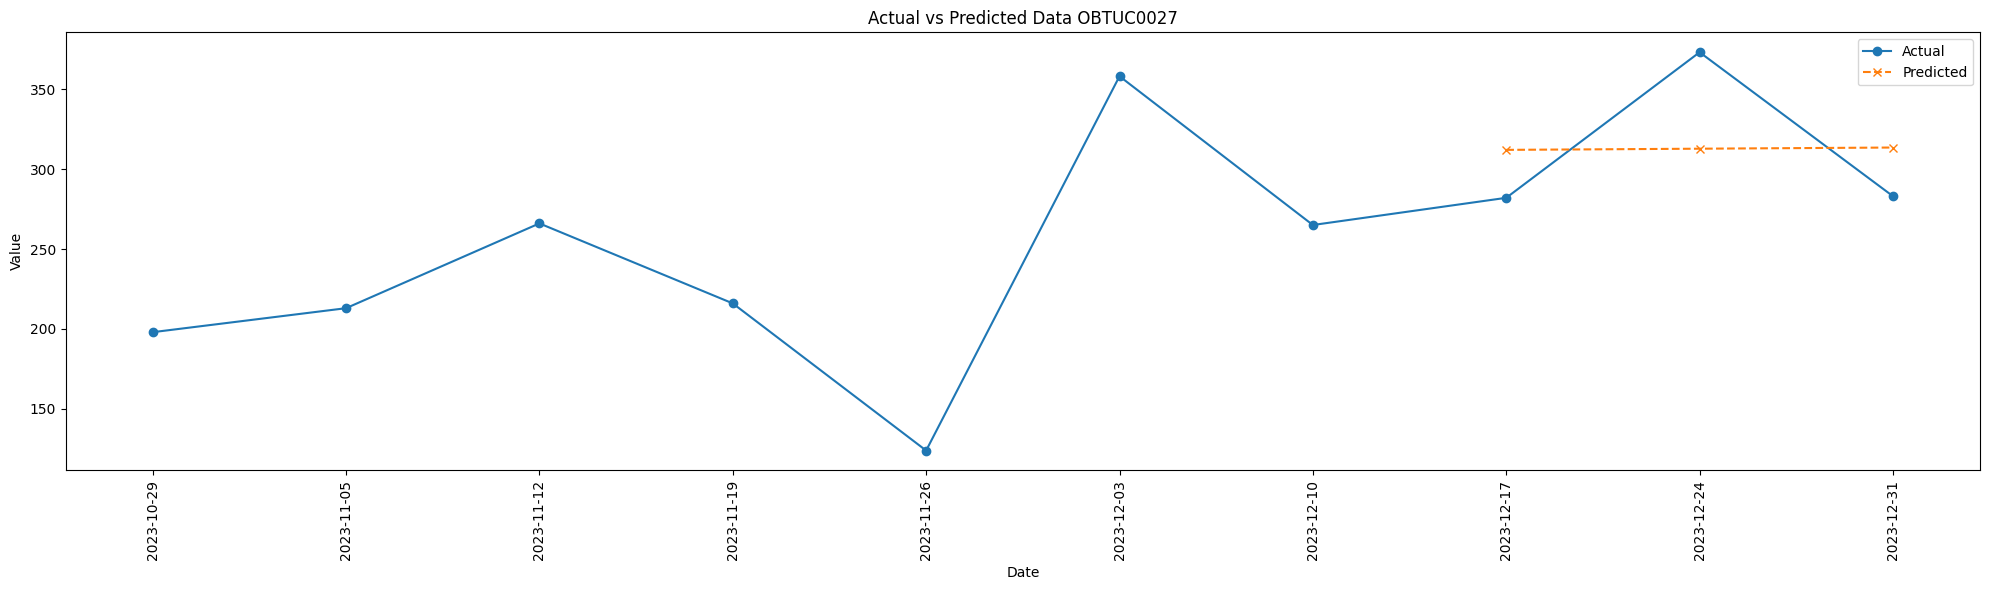

In [ ]:
aktual_OBTUC0027_fig = pr_ds_OBTUC0027.tail(10)
predicted_OBTUC0027_fig = forecast_OBTUC0027

plt.figure(figsize=(20, 6))
plt.plot(aktual_OBTUC0027_fig['ds'], aktual_OBTUC0027_fig['y'], linestyle='-',label='Actual', marker='o')
plt.plot(predicted_OBTUC0027_fig.ds, predicted_OBTUC0027_fig.yhat, label='Predicted', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Data OBTUC0027')
plt.xticks(aktual_OBTUC0027_fig['ds'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
pr_ds_ALKUF0024 = pd.read_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_weekly_ALKUF0024.csv')
pr_ds_ALKUF0024.head()

,Week,Jumlah_ALKUF0024
0,2020-12-28/2021-01-03,3.0
1,2021-01-04/2021-01-10,5.0
2,2021-01-11/2021-01-17,5.0
3,2021-01-18/2021-01-24,13.0
4,2021-01-25/2021-01-31,8.0


In [ ]:
# Selecting the last element from the resulting lists
pr_ds_ALKUF0024['Week'] = pr_ds_ALKUF0024['Week'].str.split('/')

pr_ds_ALKUF0024['Week'] = pr_ds_ALKUF0024['Week'].apply(lambda x: x[-1])

pr_ds_ALKUF0024['Week'] = pd.to_datetime(pr_ds_ALKUF0024['Week'])

pr_ds_ALKUF0024.tail()

,Week,Jumlah_ALKUF0024
152,2023-12-03,6.0
153,2023-12-10,4.0
154,2023-12-17,4.0
155,2023-12-24,5.0
156,2023-12-31,4.0


In [ ]:
pr_ds_ALKUF0024.dtypes

pr_ds_ALKUF0024.rename(columns={'Week': 'ds', 'Jumlah_ALKUF0024': 'y'}, inplace=True)

pr_ds_ALKUF0024

,ds,y
0,2021-01-03,3.0
1,2021-01-10,5.0
2,2021-01-17,5.0
3,2021-01-24,13.0
4,2021-01-31,8.0
...,...,...
152,2023-12-03,6.0
153,2023-12-10,4.0
154,2023-12-17,4.0
155,2023-12-24,5.0


In [ ]:
from prophet import Prophet

m_ALKUF0024 = Prophet(interval_width=0.95, weekly_seasonality=True)
model_ALKUF0024 = m_ALKUF0024.fit(pr_ds_ALKUF0024.tail(3))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvvxiq8eb/suwig8ur.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvvxiq8eb/xiicqzbp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5739', 'data', 'file=/tmp/tmpvvxiq8eb/suwig8ur.json', 'init=/tmp/tmpvvxiq8eb/xiicqzbp.json', 'output', 'file=/tmp/tmpvvxiq8eb/prophet_modelm_5rsijm/prophet_model-20240522045345.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:53:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:53:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cm

In [ ]:
future_ALKUF0024 = m_ALKUF0024.make_future_dataframe(periods=0, freq='W')
forecast_ALKUF0024 = m_ALKUF0024.predict(future_ALKUF0024)
forecast_ALKUF0024 = forecast_ALKUF0024[['ds', 'yhat']]
forecast_ALKUF0024.tail(10)

,ds,yhat
0,2023-12-17,4.335168
1,2023-12-24,4.335871
2,2023-12-31,4.336573


In [ ]:
aktual_ALKUF0024 = pr_ds_ALKUF0024.iloc[len(pr_ds_ALKUF0024)-3:]
prediksi_ALKUF0024 = forecast_ALKUF0024
print('data prediksi',prediksi_ALKUF0024)
print('data aktual',aktual_ALKUF0024)

aktual_ALKUF0024_err = aktual_ALKUF0024['y']
prediksi_ALKUF0024_err = prediksi_ALKUF0024['yhat']

merged_data = pd.merge(prediksi_ALKUF0024, aktual_ALKUF0024, on='ds')
merged_data['abs_pct_error'] = abs((merged_data['y'] - merged_data['yhat']) / merged_data['y']) * 100
mape = merged_data['abs_pct_error'].mean()

merged_data['squared_pct_error'] = ((merged_data['y'] - merged_data['yhat']) / merged_data['y']) ** 2
mean_squared_pct_error = merged_data['squared_pct_error'].mean()
rmspe = (mean_squared_pct_error ** 0.5) * 100

stddev_predicted_ALKUF0024 = np.std(prediksi_ALKUF0024_err)

print(f'MAPE: {mape}%')
print(f'RMSPE: {rmspe}%')
print(f'Std Deviasi: {stddev_predicted_ALKUF0024}')

data prediksi           ds      yhat
0 2023-12-17  4.335168
1 2023-12-24  4.335871
2 2023-12-31  4.336573
data aktual             ds    y
154 2023-12-17  4.0
155 2023-12-24  5.0
156 2023-12-31  4.0
MAPE: 10.025373636674539%
RMSPE: 10.286546485990696%
Std Deviasi: 0.0005735647884961024


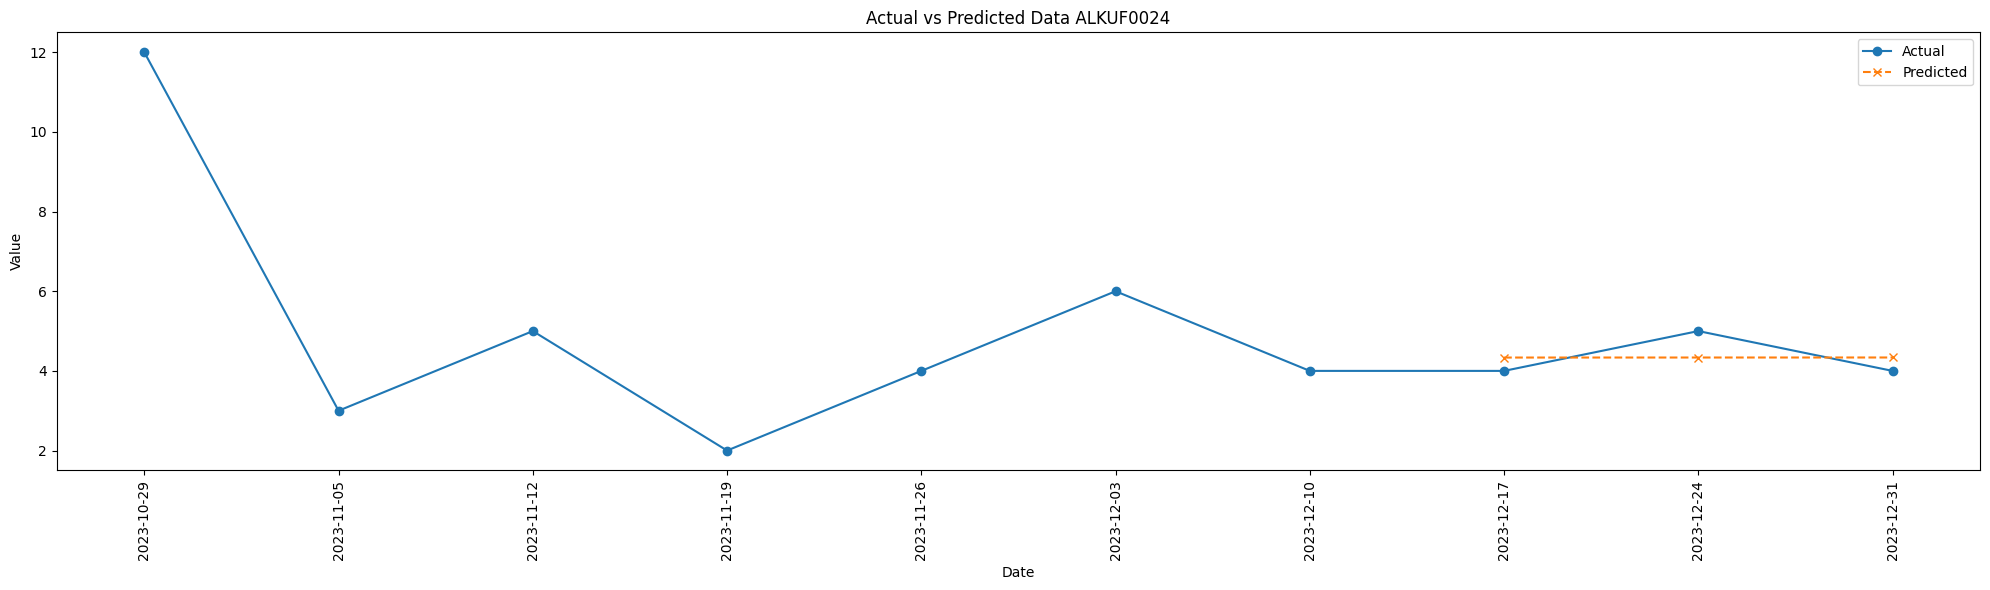

In [ ]:
aktual_ALKUF0024_fig = pr_ds_ALKUF0024.tail(10)
predicted_ALKUF0024_fig = forecast_ALKUF0024

plt.figure(figsize=(20, 6))
plt.plot(aktual_ALKUF0024_fig['ds'], aktual_ALKUF0024_fig['y'], linestyle='-',label='Actual', marker='o')
plt.plot(predicted_ALKUF0024_fig.ds, predicted_ALKUF0024_fig.yhat, label='Predicted', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Data ALKUF0024')
plt.xticks(aktual_ALKUF0024_fig['ds'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
pr_ds_OBTUD0042 = pd.read_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_weekly_OBTUD0042.csv')
pr_ds_OBTUD0042.head()

,Week,Jumlah_OBTUD0042
0,2020-12-28/2021-01-03,30.0
1,2021-01-04/2021-01-10,120.0
2,2021-01-11/2021-01-17,45.0
3,2021-01-18/2021-01-24,116.0
4,2021-01-25/2021-01-31,10.0


In [ ]:
# Selecting the last element from the resulting lists
pr_ds_OBTUD0042['Week'] = pr_ds_OBTUD0042['Week'].str.split('/')

pr_ds_OBTUD0042['Week'] = pr_ds_OBTUD0042['Week'].apply(lambda x: x[-1])

pr_ds_OBTUD0042['Week'] = pd.to_datetime(pr_ds_OBTUD0042['Week'])

pr_ds_OBTUD0042.tail()

,Week,Jumlah_OBTUD0042
152,2023-12-03,336.0
153,2023-12-10,119.0
154,2023-12-17,317.0
155,2023-12-24,289.0
156,2023-12-31,133.0


In [ ]:
pr_ds_OBTUD0042.dtypes

pr_ds_OBTUD0042.rename(columns={'Week': 'ds', 'Jumlah_OBTUD0042': 'y'}, inplace=True)

pr_ds_OBTUD0042

,ds,y
0,2021-01-03,30.0
1,2021-01-10,120.0
2,2021-01-17,45.0
3,2021-01-24,116.0
4,2021-01-31,10.0
...,...,...
152,2023-12-03,336.0
153,2023-12-10,119.0
154,2023-12-17,317.0
155,2023-12-24,289.0


In [ ]:
from prophet import Prophet

m_OBTUD0042 = Prophet(interval_width=0.95, weekly_seasonality=True)
model_OBTUD0042 = m_OBTUD0042.fit(pr_ds_OBTUD0042.tail(3))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvvxiq8eb/uy2e8kxa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvvxiq8eb/dn0br_m4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86492', 'data', 'file=/tmp/tmpvvxiq8eb/uy2e8kxa.json', 'init=/tmp/tmpvvxiq8eb/dn0br_m4.json', 'output', 'file=/tmp/tmpvvxiq8eb/prophet_modeluonge63g/prophet_model-20240522044847.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:48:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:48:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

In [ ]:
future_OBTUD0042 = m_OBTUD0042.make_future_dataframe(periods=0, freq='W')
forecast_OBTUD0042 = m_OBTUD0042.predict(future_OBTUD0042)
forecast_OBTUD0042 = forecast_OBTUD0042[['ds', 'yhat']]
forecast_OBTUD0042.tail()

,ds,yhat
0,2023-12-17,338.420872
1,2023-12-24,246.450296
2,2023-12-31,154.479720


In [ ]:
aktual_OBTUD0042 = pr_ds_OBTUD0042.iloc[len(pr_ds_OBTUD0042)-3:]
prediksi_OBTUD0042 = forecast_OBTUD0042
print('data prediksi',prediksi_OBTUD0042)
print('data aktual',aktual_OBTUD0042)

aktual_OBTUD0042_err = aktual_OBTUD0042['y']
prediksi_OBTUD0042_err = prediksi_OBTUD0042['yhat']

merged_data = pd.merge(prediksi_OBTUD0042, aktual_OBTUD0042, on='ds')
merged_data['abs_pct_error'] = abs((merged_data['y'] - merged_data['yhat']) / merged_data['y']) * 100
mape = merged_data['abs_pct_error'].mean()

merged_data['squared_pct_error'] = ((merged_data['y'] - merged_data['yhat']) / merged_data['y']) ** 2
mean_squared_pct_error = merged_data['squared_pct_error'].mean()
rmspe = (mean_squared_pct_error ** 0.5) * 100

stddev_predicted_OBTUD0042 = np.std(prediksi_OBTUD0042_err)

print(f'MAPE: {mape}%')
print(f'RMSPE: {rmspe}%')
print(f'stddev: {stddev_predicted_OBTUD0042}')

data prediksi           ds        yhat
0 2023-12-17  338.420872
1 2023-12-24  246.450296
2 2023-12-31  154.479720
data aktual             ds      y
154 2023-12-17  317.0
155 2023-12-24  289.0
156 2023-12-31  133.0
MAPE: 12.54353966844378%
RMSPE: 13.206804257572072%
stddev: 75.09366099383496


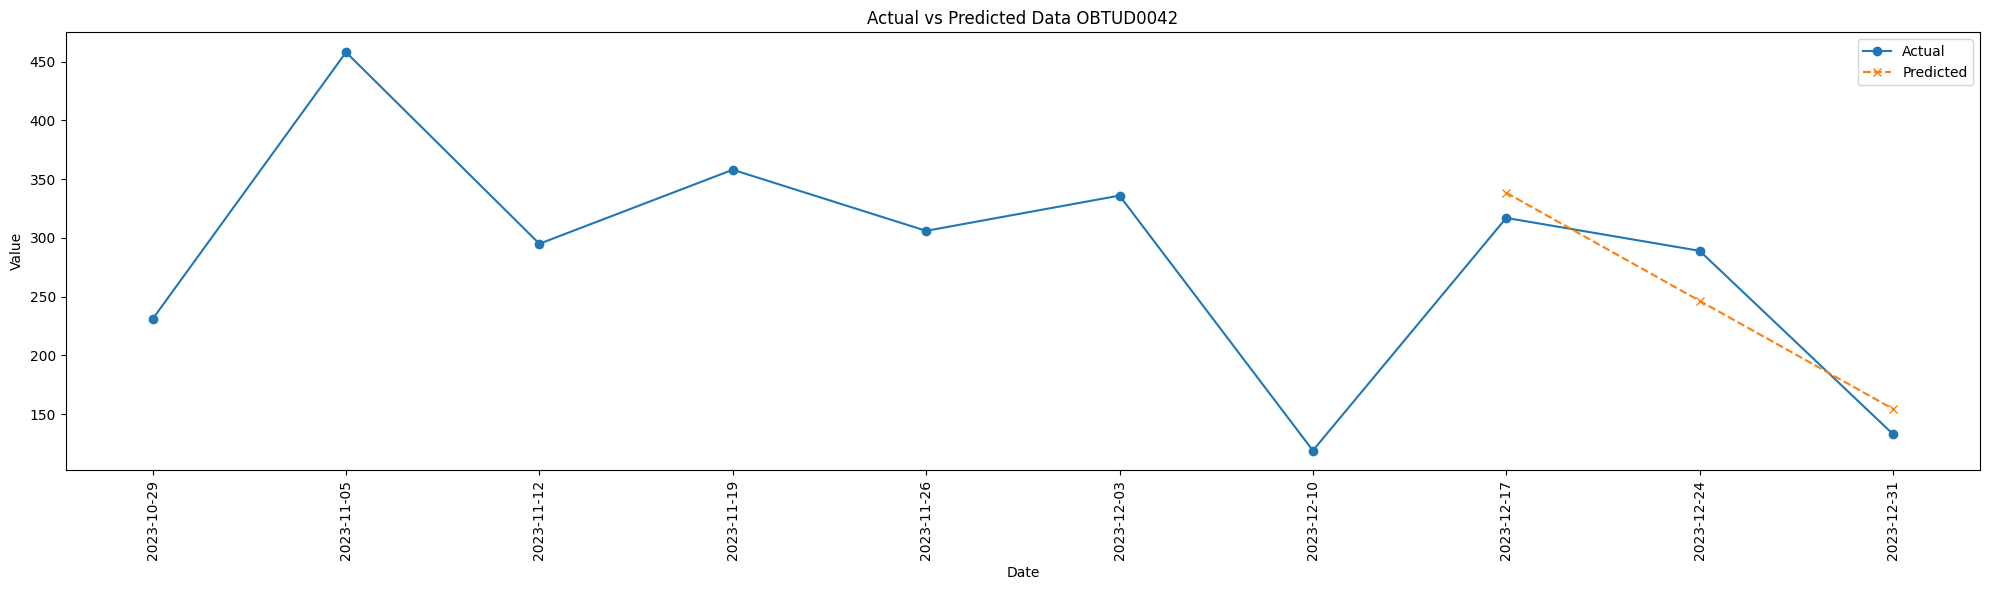

In [ ]:
aktual_OBTUD0042_fig = pr_ds_OBTUD0042.tail(10)
predicted_OBTUD0042_fig = forecast_OBTUD0042

plt.figure(figsize=(20, 6))
plt.plot(aktual_OBTUD0042_fig['ds'], aktual_OBTUD0042_fig['y'], linestyle='-',label='Actual', marker='o')
plt.plot(predicted_OBTUD0042_fig.ds, predicted_OBTUD0042_fig.yhat, label='Predicted', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Data OBTUD0042')
plt.xticks(aktual_OBTUD0042_fig['ds'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
pr_ds_ALKUT0020 = pd.read_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_weekly_ALKUT0020.csv')
pr_ds_ALKUT0020.head()

,Week,Jumlah_ALKUT0020
0,2020-12-28/2021-01-03,12.0
1,2021-01-04/2021-01-10,6.0
2,2021-01-11/2021-01-17,11.0
3,2021-01-18/2021-01-24,10.0
4,2021-01-25/2021-01-31,10.0


In [ ]:
# Selecting the last element from the resulting lists
pr_ds_ALKUT0020['Week'] = pr_ds_ALKUT0020['Week'].str.split('/')

pr_ds_ALKUT0020['Week'] = pr_ds_ALKUT0020['Week'].apply(lambda x: x[-1])

pr_ds_ALKUT0020['Week'] = pd.to_datetime(pr_ds_ALKUT0020['Week'])

pr_ds_ALKUT0020.tail()

,Week,Jumlah_ALKUT0020
152,2023-12-03,110.0
153,2023-12-10,75.0
154,2023-12-17,102.0
155,2023-12-24,82.0
156,2023-12-31,75.0


In [ ]:
pr_ds_ALKUT0020.dtypes

pr_ds_ALKUT0020.rename(columns={'Week': 'ds', 'Jumlah_ALKUT0020': 'y'}, inplace=True)

pr_ds_ALKUT0020

,ds,y
0,2021-01-03,12.0
1,2021-01-10,6.0
2,2021-01-17,11.0
3,2021-01-24,10.0
4,2021-01-31,10.0
...,...,...
152,2023-12-03,110.0
153,2023-12-10,75.0
154,2023-12-17,102.0
155,2023-12-24,82.0


In [ ]:
from prophet import Prophet

m_ALKUT0020 = Prophet(interval_width=0.95, weekly_seasonality=True)
model_ALKUT0020 = m_ALKUT0020.fit(pr_ds_ALKUT0020.tail(3))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvvxiq8eb/gah5rfln.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvvxiq8eb/n0_o6eiz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71243', 'data', 'file=/tmp/tmpvvxiq8eb/gah5rfln.json', 'init=/tmp/tmpvvxiq8eb/n0_o6eiz.json', 'output', 'file=/tmp/tmpvvxiq8eb/prophet_modelo07t2lsy/prophet_model-20240522044617.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:46:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:46:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

In [ ]:
future_ALKUT0020 = m_ALKUT0020.make_future_dataframe(periods=0, freq='W')
forecast_ALKUT0020 = m_ALKUT0020.predict(future_ALKUT0020)
forecast_ALKUT0020 = forecast_ALKUT0020[['ds', 'yhat']]
forecast_ALKUT0020.tail()

,ds,yhat
0,2023-12-17,99.856651
1,2023-12-24,86.326300
2,2023-12-31,72.795949


In [ ]:
aktual_ALKUT0020 = pr_ds_ALKUT0020.iloc[len(pr_ds_ALKUT0020)-3:]
prediksi_ALKUT0020 = forecast_ALKUT0020
print('data prediksi',prediksi_ALKUT0020)
print('data aktual',aktual_ALKUT0020)

aktual_ALKUT0020_err = aktual_ALKUT0020['y']
prediksi_ALKUT0020_err = prediksi_ALKUT0020['yhat']

merged_data = pd.merge(prediksi_ALKUT0020, aktual_ALKUT0020, on='ds')
merged_data['abs_pct_error'] = abs((merged_data['y'] - merged_data['yhat']) / merged_data['y']) * 100
mape = merged_data['abs_pct_error'].mean()

merged_data['squared_pct_error'] = ((merged_data['y'] - merged_data['yhat']) / merged_data['y']) ** 2
mean_squared_pct_error = merged_data['squared_pct_error'].mean()
rmspe = (mean_squared_pct_error ** 0.5) * 100

stddev_predicted_ALKUT0020 = np.std(prediksi_ALKUT0020_err)

print(f'MAPE: {mape}%')
print(f'RMSPE: {rmspe}%')
print(f'stddev: {stddev_predicted_ALKUT0020}')

data prediksi           ds       yhat
0 2023-12-17  99.856651
1 2023-12-24  86.326300
2 2023-12-31  72.795949
data aktual             ds      y
154 2023-12-17  102.0
155 2023-12-24   82.0
156 2023-12-31   75.0
MAPE: 3.4386774499537753%
RMSPE: 3.691776268779566%
stddev: 11.047485290519967


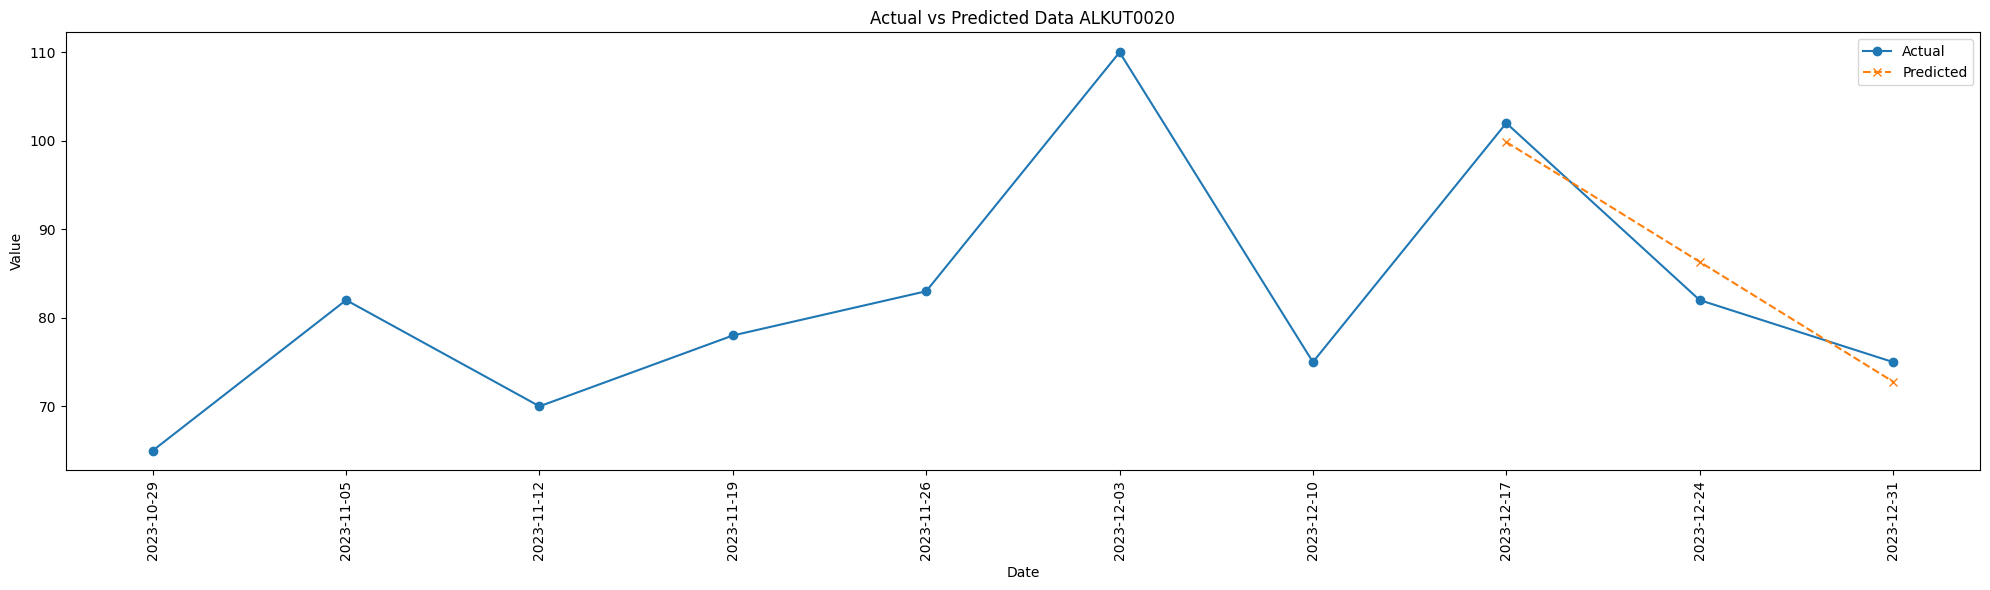

In [ ]:
aktual_ALKUT0020_fig = pr_ds_ALKUT0020.tail(10)
predicted_ALKUT0020_fig = forecast_ALKUT0020

plt.figure(figsize=(20, 6))
plt.plot(aktual_ALKUT0020_fig['ds'], aktual_ALKUT0020_fig['y'], linestyle='-',label='Actual', marker='o')
plt.plot(predicted_ALKUT0020_fig.ds, predicted_ALKUT0020_fig.yhat, label='Predicted', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Data ALKUT0020')
plt.xticks(aktual_ALKUT0020_fig['ds'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
pr_ds_OBTUD0011 = pd.read_csv('/content/drive/MyDrive/KULIAH_S2/Tesis/dataset/sales_item_weekly_OBTUD0011.csv')
pr_ds_OBTUD0011.head()

,Week,Jumlah_OBTUD0011
0,2020-12-28/2021-01-03,14.0
1,2021-01-04/2021-01-10,36.0
2,2021-01-11/2021-01-17,44.0
3,2021-01-18/2021-01-24,14.0
4,2021-01-25/2021-01-31,30.0


In [ ]:
# Selecting the last element from the resulting lists
pr_ds_OBTUD0011['Week'] = pr_ds_OBTUD0011['Week'].str.split('/')

pr_ds_OBTUD0011['Week'] = pr_ds_OBTUD0011['Week'].apply(lambda x: x[-1])

pr_ds_OBTUD0011['Week'] = pd.to_datetime(pr_ds_OBTUD0011['Week'])

pr_ds_OBTUD0011.tail()

,Week,Jumlah_OBTUD0011
152,2023-12-03,641.0
153,2023-12-10,606.0
154,2023-12-17,737.0
155,2023-12-24,853.0
156,2023-12-31,757.0


In [ ]:
pr_ds_OBTUD0011.dtypes

pr_ds_OBTUD0011.rename(columns={'Week': 'ds', 'Jumlah_OBTUD0011': 'y'}, inplace=True)

pr_ds_OBTUD0011

,ds,y
0,2021-01-03,14.0
1,2021-01-10,36.0
2,2021-01-17,44.0
3,2021-01-24,14.0
4,2021-01-31,30.0
...,...,...
152,2023-12-03,641.0
153,2023-12-10,606.0
154,2023-12-17,737.0
155,2023-12-24,853.0


In [ ]:
from prophet import Prophet

m_OBTUD0011 = Prophet(interval_width=0.95, weekly_seasonality=True)
model_OBTUD0011 = m_OBTUD0011.fit(pr_ds_OBTUD0011.tail(3))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvvxiq8eb/lwj4j9aa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvvxiq8eb/f3sq04ch.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21046', 'data', 'file=/tmp/tmpvvxiq8eb/lwj4j9aa.json', 'init=/tmp/tmpvvxiq8eb/f3sq04ch.json', 'output', 'file=/tmp/tmpvvxiq8eb/prophet_model5s5e3txp/prophet_model-20240522045123.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:51:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:51:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

In [ ]:
future_OBTUD0011 = m_OBTUD0011.make_future_dataframe(periods=0, freq='W')
forecast_OBTUD0011 = m_OBTUD0011.predict(future_OBTUD0011)
forecast_OBTUD0011 = forecast_OBTUD0011[['ds', 'yhat']]
forecast_OBTUD0011

,ds,yhat
0,2023-12-17,772.445473
1,2023-12-24,782.453680
2,2023-12-31,792.461886


In [ ]:
aktual_OBTUD0011 = pr_ds_OBTUD0011.iloc[len(pr_ds_OBTUD0011)-3:]
prediksi_OBTUD0011 = forecast_OBTUD0011
print('data prediksi',prediksi_OBTUD0011)
print('data aktual',aktual_OBTUD0011)

aktual_OBTUD0011_err = aktual_OBTUD0011['y']
prediksi_OBTUD0011_err = prediksi_OBTUD0011['yhat']

merged_data = pd.merge(prediksi_OBTUD0011, aktual_OBTUD0011, on='ds')
merged_data['abs_pct_error'] = abs((merged_data['y'] - merged_data['yhat']) / merged_data['y']) * 100
mape = merged_data['abs_pct_error'].mean()

merged_data['squared_pct_error'] = ((merged_data['y'] - merged_data['yhat']) / merged_data['y']) ** 2
mean_squared_pct_error = merged_data['squared_pct_error'].mean()
rmspe = (mean_squared_pct_error ** 0.5) * 100

stddev_predicted_OBTUD0011 = np.std(prediksi_OBTUD0011_err)

print(f'MAPE: {mape}%')
print(f'RMSPE: {rmspe}%')
print(f'stddev: {stddev_predicted_OBTUD0011}')

data prediksi           ds        yhat
0 2023-12-17  772.445473
1 2023-12-24  782.453680
2 2023-12-31  792.461886
data aktual             ds      y
154 2023-12-17  737.0
155 2023-12-24  853.0
156 2023-12-31  757.0
MAPE: 5.921444401454902%
RMSPE: 6.150190820550723%
stddev: 8.171666222147445


In [ ]:
a = aktual_ALKUT0020_err - prediksi_OBTUD0011_err
print(a)

0     NaN
1     NaN
2     NaN
154   NaN
155   NaN
156   NaN
dtype: float64


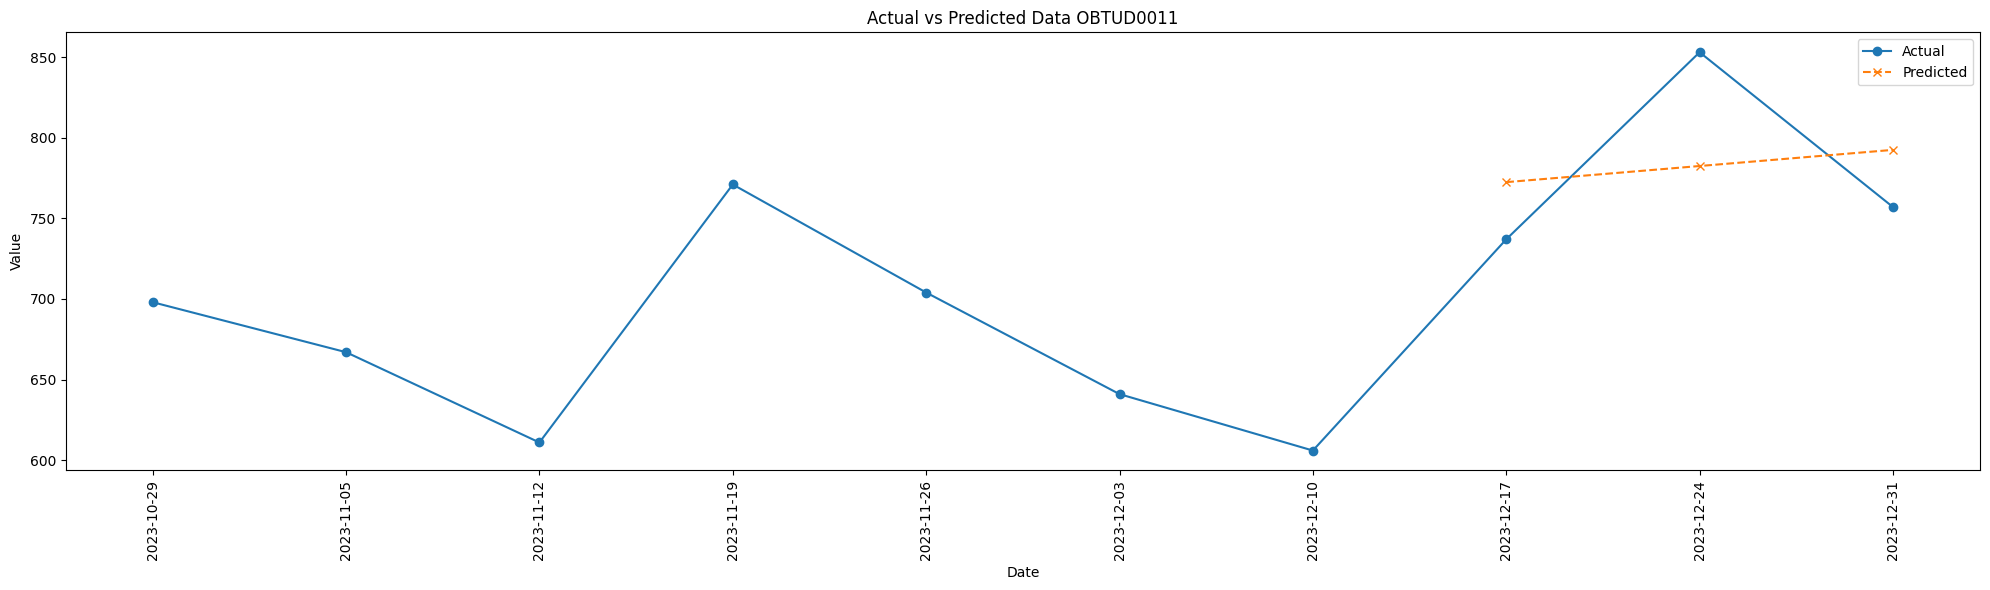

In [ ]:
aktual_OBTUD0011_fig = pr_ds_OBTUD0011.tail(10)
predicted_OBTUD0011_fig = forecast_OBTUD0011

plt.figure(figsize=(20, 6))
plt.plot(aktual_OBTUD0011_fig['ds'], aktual_OBTUD0011_fig['y'], linestyle='-',label='Actual', marker='o')
plt.plot(predicted_OBTUD0011_fig.ds, predicted_OBTUD0011_fig.yhat, label='Predicted', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Data OBTUD0011')
plt.xticks(aktual_OBTUD0011_fig['ds'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()